# Проект задача мэтчинга

Задача мэтчинга. Необходимо подготовить модель которая предложит товар схожий по признакам

In [1]:
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import time
from phik.report import plot_correlation_matrix
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler

# Загрузка и изучение данных

In [2]:
df_base = pd.read_csv('base.csv', index_col=0)
df_train = pd.read_csv('train.csv', index_col=0)
df_val = pd.read_csv('validation.csv', index_col=0)
df_ans = pd.read_csv('validation_answer.csv', index_col=0)

In [3]:
# Функция для первичного изучения данных
def data_exploration(dataframe):
    print('\033[1m' + 'Информация о датафрейме:')
    print('\033[0m')
    dataframe.info()
    
    print('\033[1m' + 'Первые пять строк:')
    print('\033[0m')
    display(dataframe.head())

# Функция для проверки на пропуски и дубликаты
def check_missing_duplicates(dataframe):
    # Проверка на пропуски в данных
    print(f'Пропуски в строках таблицы:')
    display(pd.DataFrame(round(dataframe.isna().mean() * 100, 2)).T.style.background_gradient('coolwarm'))
    
    # Проверка на дубликаты
    duplicates = dataframe.duplicated().sum()
    print(f'Количество дубликатов в таблице: {duplicates}')    

## Изучение df_base

In [4]:
data_exploration(df_base)

Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float64
 1   1       291813 non-null  float64
 2   2       291813 non-null  float64
 3   3       291813 non-null  float64
 4   4       291813 non-null  float64
 5   5       291813 non-null  float64
 6   6       291813 non-null  float64
 7   7       291813 non-null  float64
 8   8       291813 non-null  float64
 9   9       291813 non-null  float64
 10  10      291813 non-null  float64
 11  11      291813 non-null  float64
 12  12      291813 non-null  float64
 13  13      291813 non-null  float64
 14  14      291813 non-null  float64
 15  15      291813 non-null  float64
 16  16      291813 non-null  float64
 17  17      291813 non-null  float64
 18  18      291813 non-null  float64
 19  19      291813 non-null  float64
 20  20      291

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,...,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,...,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,...,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,...,-30.002094,53.642930,-149.823230,176.921371,69.473280,-43.395180,-58.947716,133.84064,-1074.464888,-1.164146


In [5]:
check_missing_duplicates(df_base)

Пропуски в строках таблицы:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Количество дубликатов в таблице: 11278


## Изучение df_train

In [6]:
data_exploration(df_train)

Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9999 non-null   float64
 1   1       9999 non-null   float64
 2   2       9999 non-null   float64
 3   3       9999 non-null   float64
 4   4       9999 non-null   float64
 5   5       9999 non-null   float64
 6   6       9999 non-null   float64
 7   7       9999 non-null   float64
 8   8       9999 non-null   float64
 9   9       9999 non-null   float64
 10  10      9999 non-null   float64
 11  11      9999 non-null   float64
 12  12      9999 non-null   float64
 13  13      9999 non-null   float64
 14  14      9999 non-null   float64
 15  15      9999 non-null   float64
 16  16      9999 non-null   float64
 17  17      9999 non-null   float64
 18  18      9999 non-null   float64
 19  19      9999 non-null   float64
 20  20      9999 non-null   float64
 21

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,...,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,...,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,...,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,...,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,...,13.807772,-208.650040,41.742014,66.522420,41.362930,162.723050,111.261310,-151.162805,-33.831450,168591-base


In [7]:
check_missing_duplicates(df_train)

Пропуски в строках таблицы:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Количество дубликатов в таблице: 243


## Изучение df_val

In [8]:
data_exploration(df_val)

Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 2

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,108.809586,...,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,95.231290,...,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,59.321335,...,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,201.146090,...,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,131.900620,...,-116.440605,47.279976,-162.65400,107.409409,67.78526,-60.976490,142.68571,82.264300,-345.340457,-48.572525


In [9]:
check_missing_duplicates(df_val)

Пропуски в строках таблицы:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Количество дубликатов в таблице: 265


## Изучение df_ans

In [10]:
data_exploration(df_ans)

Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Expected  10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB
Первые пять строк:



,Expected
Id,
196680-query,1087368-base
134615-query,849674-base
82675-query,4183486-base
162076-query,2879258-base
23069-query,615229-base


In [11]:
check_missing_duplicates(df_ans)

Пропуски в строках таблицы:


,Expected
0,0.000000


Количество дубликатов в таблице: 360


## Результаты изучения данных

__Итоги изучения датафрейма df_base:__

- Базовый датафрейм имеет 291813 строк, 73 столбца, включая индекс в виде ID и 72 признаков
- Пропуски не обнаружены
- Имеется 11278 дубликатов

__Итоги изучения датафрейма df_train:__
- Датафрейм содержит 9999 строк, 74 столбца, включая индекс в виде ID, 72 признака и столбец с таргетом
- Пропуски не обнаружены
- Дубликатов 243

__Итоги изучения датафрейма df_val:__
- Датафрейм содержит 10000 строк, 73 столбца, включая индекс в виде ID, 72 признака 
- Пропуски не обнаружены
- Дубликатов 265

__Итоги изучения датафрейма df_ans:__
- Датафрейм содержит 10000 строк, 1 столбец с ожидаемым результатом
- Пропуски отсутствуют
- Дубликатов 360

# Исследовательский анализ данных

In [12]:
num_columns = df_base.select_dtypes(include='number').columns.tolist()

In [13]:
# Функция для вычисления нижнего и верхнего пределов для определения выбросов
def outlier_detection(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range


# Функция для вывода анализа количественных данных
def plot_numerical_features(dataframe, features):
    for feature in features:
        if feature != 'id' and pd.api.types.is_numeric_dtype(dataframe[feature]):
            #Построение гистограммы и ящика с усами
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            sns.histplot(dataframe[feature], kde=True, ax=axes[0], log_scale=False, palette="viridis")
            axes[0].set_title(f'Гистограмма {feature}')
            sns.boxplot(y=dataframe[feature], ax=axes[1])
            axes[1].set_title(f'Разброс {feature}')
            plt.show()  
            # Отображение описательной статистики
            display(dataframe[feature].describe().to_frame().T)
            
            # Вычисление и вывод нижнего и верхнего пределов для выбросов
            lower_range, upper_range = outlier_detection(dataframe[feature])
            print(f'Нижняя граница выбросов признака {feature}: {lower_range}')
            print(f'Верхняя граница выбросов признака {feature}: {upper_range}')
            
            # Подсчет значений за пределами границ
            below_lower = dataframe[dataframe[feature] < lower_range].shape[0]
            above_upper = dataframe[dataframe[feature] > upper_range].shape[0]
            print(f'Количество значений за нижней границей {feature}: {below_lower}')

## Анализ числовых данных

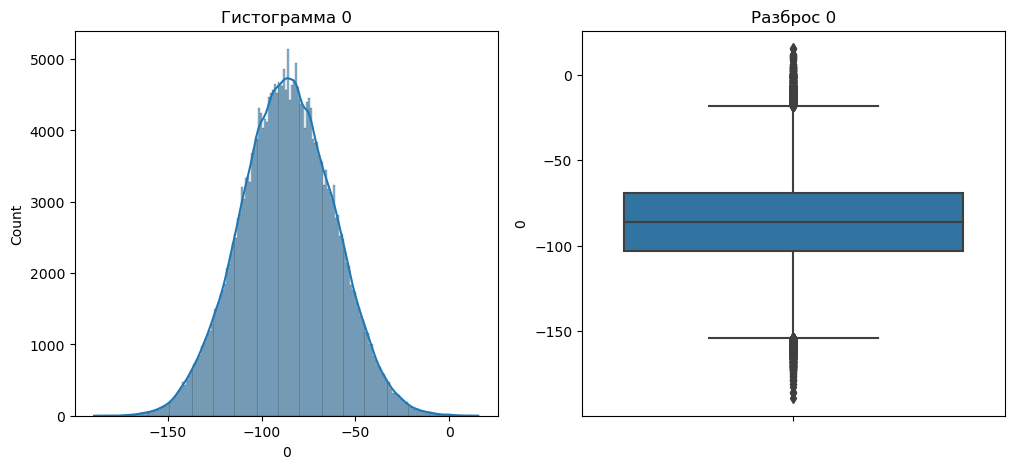

,count,mean,std,min,25%,50%,75%,max
0,291813.0,-86.274741,24.918947,-189.35602,-103.1543,-86.30813,-69.254616,15.574616


Нижняя граница выбросов признака 0: -154.003826
Верхняя граница выбросов признака 0: -18.405089999999987
Количество значений за нижней границей 0: 764


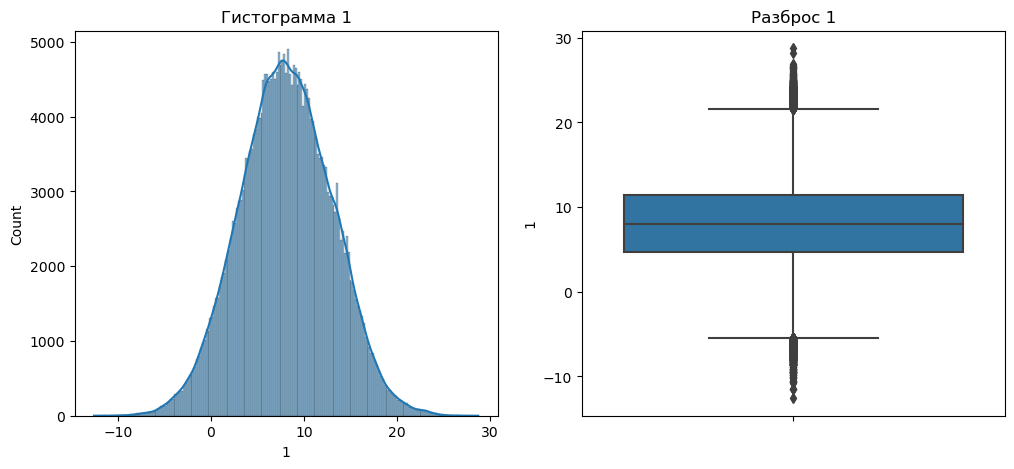

,count,mean,std,min,25%,50%,75%,max
1,291813.0,8.078087,4.949495,-12.5945,4.709408,8.04001,11.466815,28.751917


Нижняя граница выбросов признака 1: -5.426702500000001
Верхняя граница выбросов признака 1: 21.6029255
Количество значений за нижней границей 1: 735


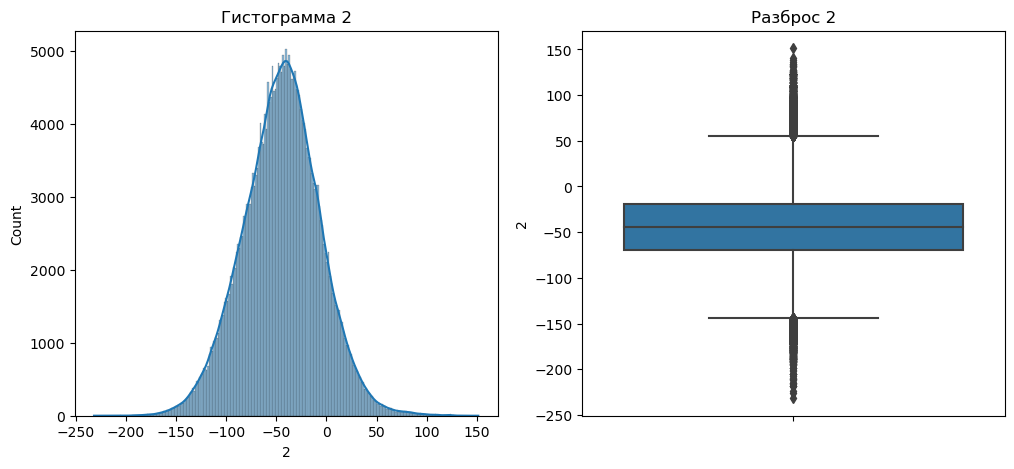

,count,mean,std,min,25%,50%,75%,max
2,291813.0,-44.61348,38.545928,-231.78592,-69.5359,-43.838493,-19.694052,151.37708


Нижняя граница выбросов признака 2: -144.298672
Верхняя граница выбросов признака 2: 55.06872
Количество значений за нижней границей 2: 1647


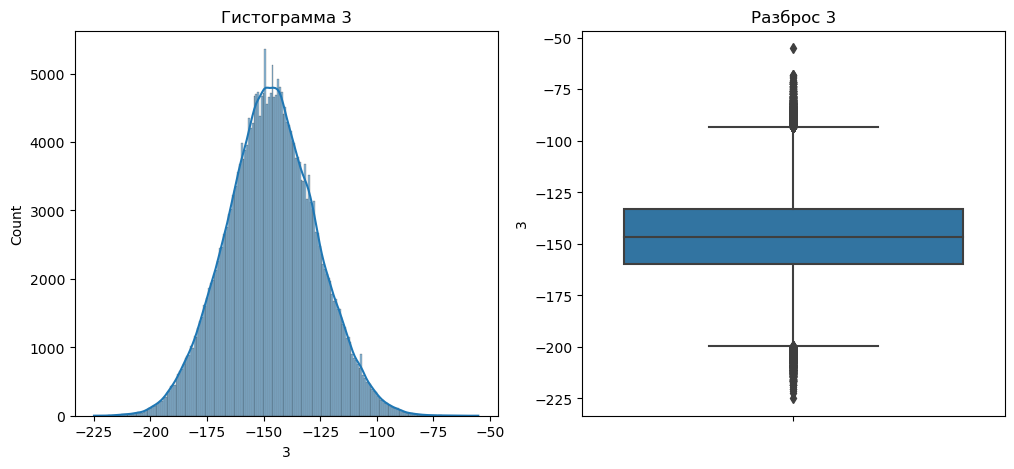

,count,mean,std,min,25%,50%,75%,max
3,291813.0,-146.605552,19.842726,-224.8805,-159.88274,-146.71736,-133.32014,-55.167892


Нижняя граница выбросов признака 3: -199.72664000000003
Верхняя граница выбросов признака 3: -93.47624
Количество значений за нижней границей 3: 832


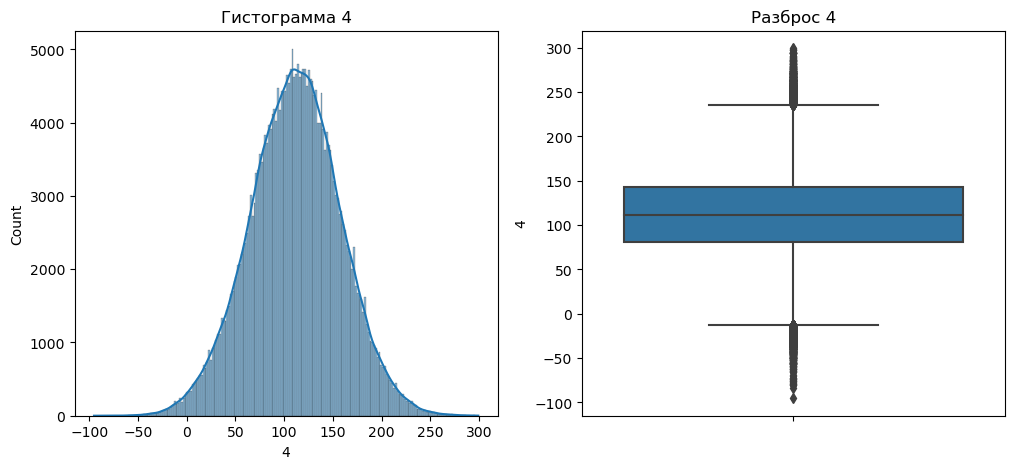

,count,mean,std,min,25%,50%,75%,max
4,291813.0,111.261183,46.350083,-95.24083,80.36764,111.77687,142.36461,299.30792


Нижняя граница выбросов признака 4: -12.627815000000012
Верхняя граница выбросов признака 4: 235.36006500000002
Количество значений за нижней границей 4: 1166


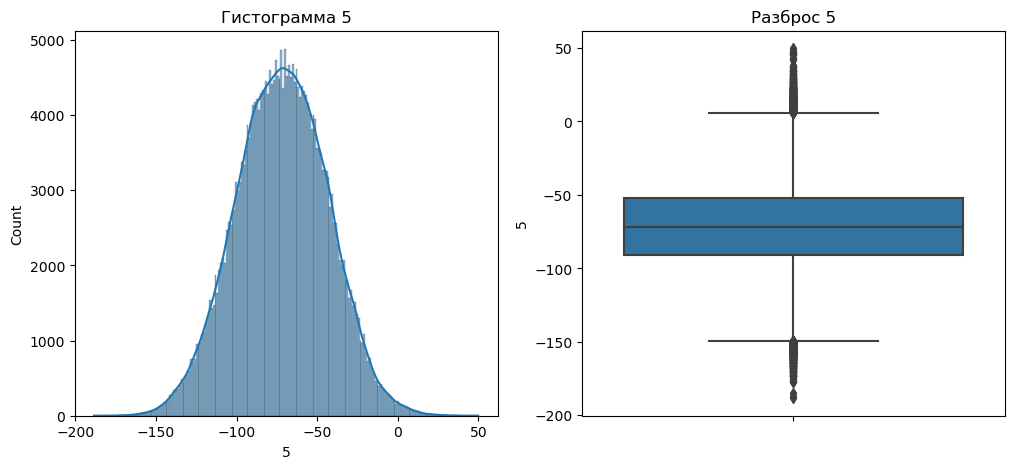

,count,mean,std,min,25%,50%,75%,max
5,291813.0,-71.875015,28.189743,-188.47333,-91.227936,-71.75182,-52.310825,49.880882


Нижняя граница выбросов признака 5: -149.6036025
Верхняя граница выбросов признака 5: 6.064841499999993
Количество значений за нижней границей 5: 598


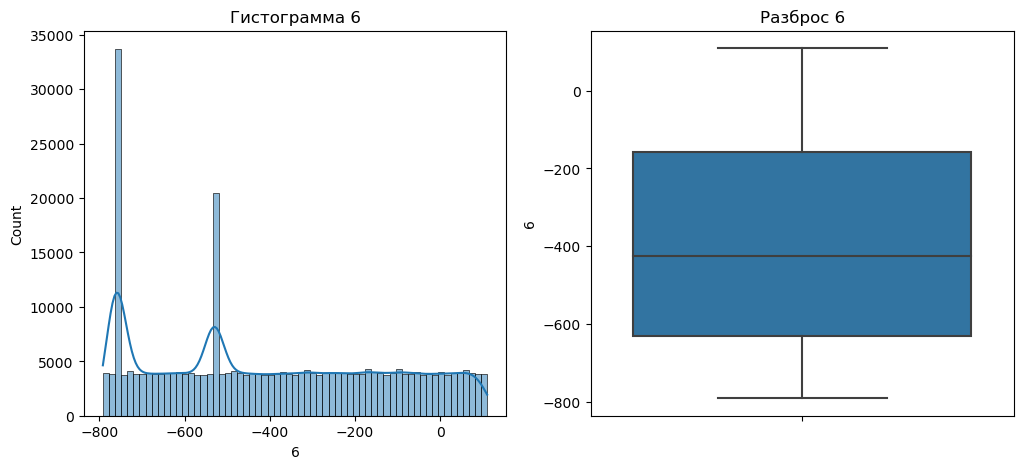

,count,mean,std,min,25%,50%,75%,max
6,291813.0,-393.43046,272.084921,-791.46877,-631.937855,-424.306925,-157.3427,109.631986


Нижняя граница выбросов признака 6: -1343.8305888312466
Верхняя граница выбросов признака 6: 554.5500335769527
Количество значений за нижней границей 6: 0


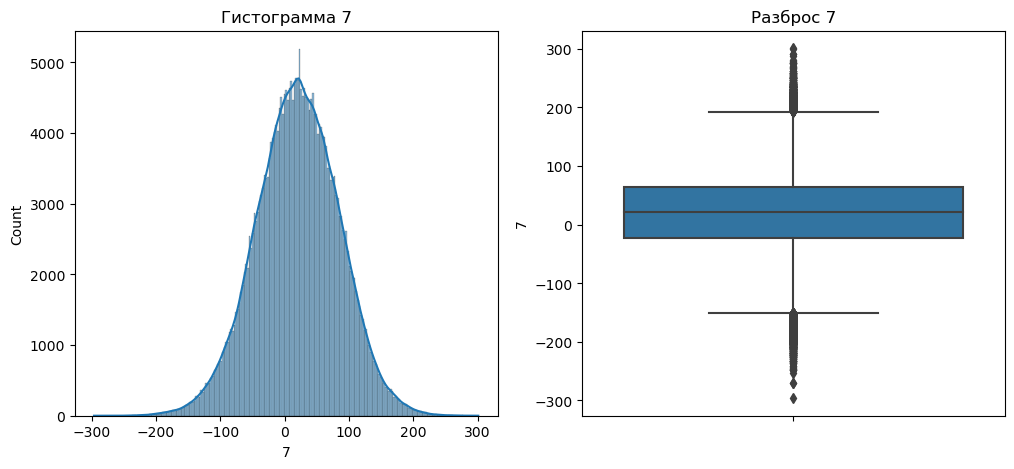

,count,mean,std,min,25%,50%,75%,max
7,291813.0,20.391975,64.297194,-296.17105,-22.085905,20.850153,63.989326,301.09424


Нижняя граница выбросов признака 7: -151.1987515
Верхняя граница выбросов признака 7: 193.1021725
Количество значений за нижней границей 7: 1550


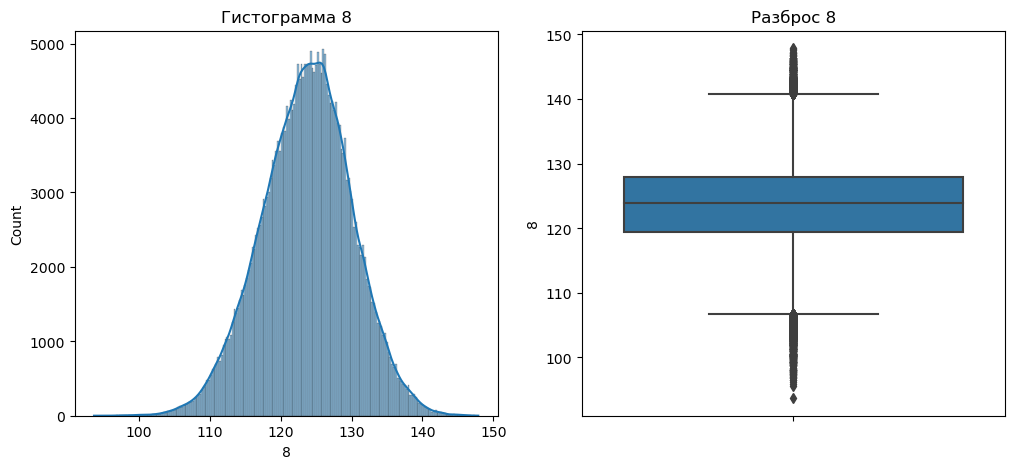

,count,mean,std,min,25%,50%,75%,max
8,291813.0,123.676692,6.352832,93.684616,119.473625,123.8825,127.967766,147.87091


Нижняя граница выбросов признака 8: 106.7324135
Верхняя граница выбросов признака 8: 140.7089775
Количество значений за нижней границей 8: 1487


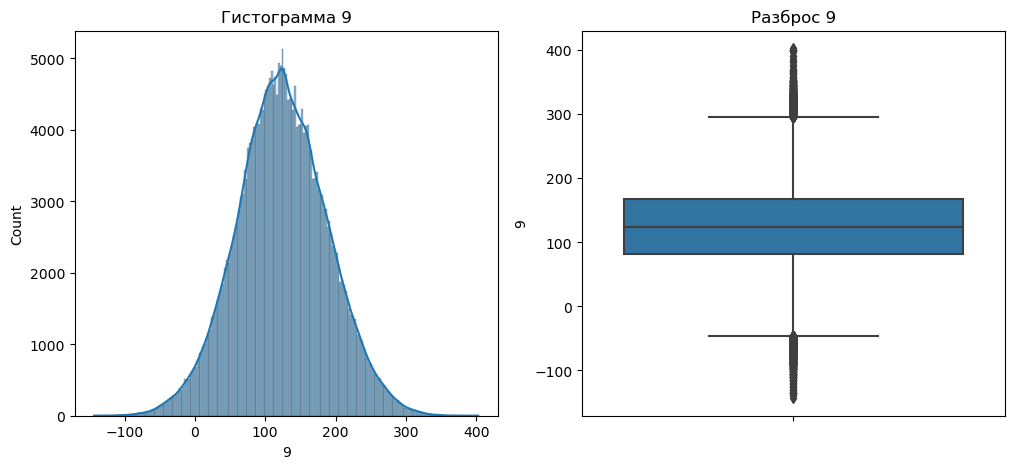

,count,mean,std,min,25%,50%,75%,max
9,291813.0,124.427158,64.366631,-143.4996,81.68561,123.45627,167.01413,402.9946


Нижняя граница выбросов признака 9: -46.30717
Верхняя граница выбросов признака 9: 295.00691
Количество значений за нижней границей 9: 1198


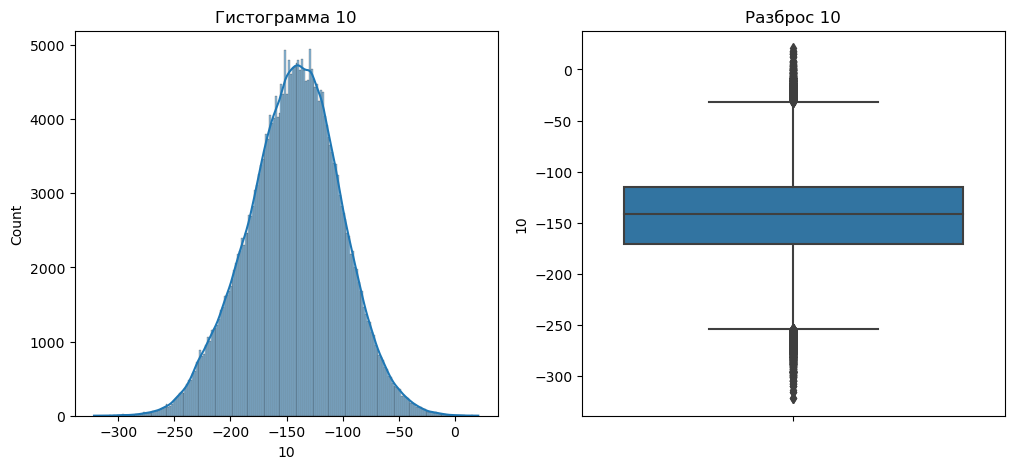

,count,mean,std,min,25%,50%,75%,max
10,291813.0,-143.241671,41.828261,-321.52258,-170.57913,-141.8316,-114.90349,20.790848


Нижняя граница выбросов признака 10: -254.09258999999997
Верхняя граница выбросов признака 10: -31.390030000000024
Количество значений за нижней границей 10: 1256


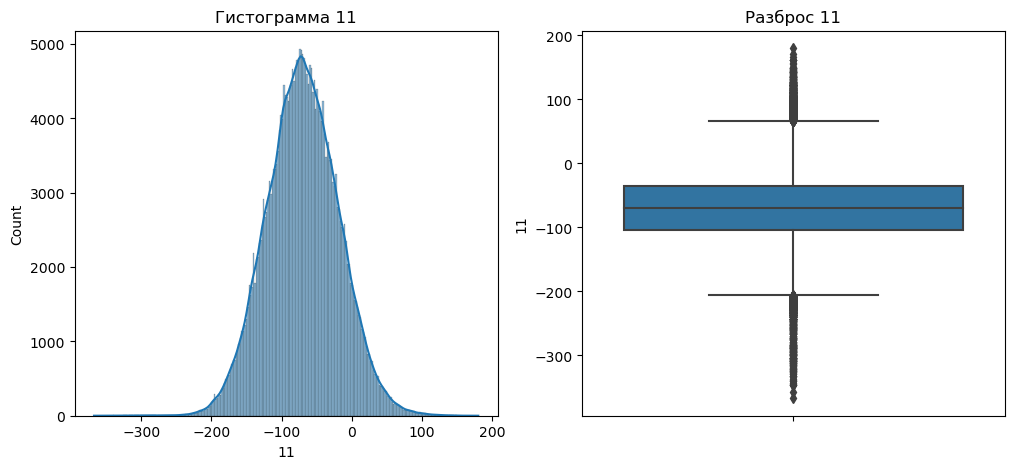

,count,mean,std,min,25%,50%,75%,max
11,291813.0,-69.943874,51.194297,-367.1307,-103.997734,-70.37659,-35.72095,180.04535


Нижняя граница выбросов признака 11: -206.41290999999998
Верхняя граница выбросов признака 11: 66.69422599999999
Количество значений за нижней границей 11: 982


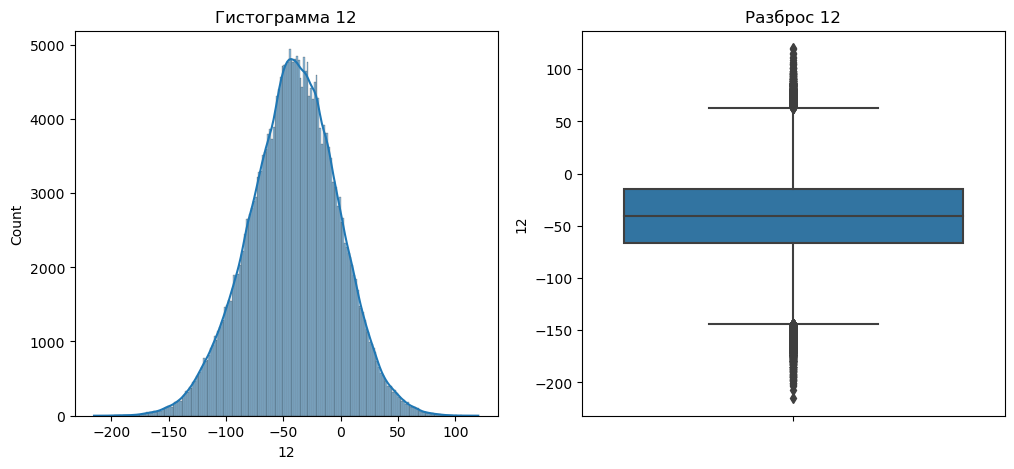

,count,mean,std,min,25%,50%,75%,max
12,291813.0,-41.180997,38.942859,-215.22353,-66.55979,-40.30698,-14.742321,119.991196


Нижняя граница выбросов признака 12: -144.28599350000002
Верхняя граница выбросов признака 12: 62.98388249999999
Количество значений за нижней границей 12: 1610


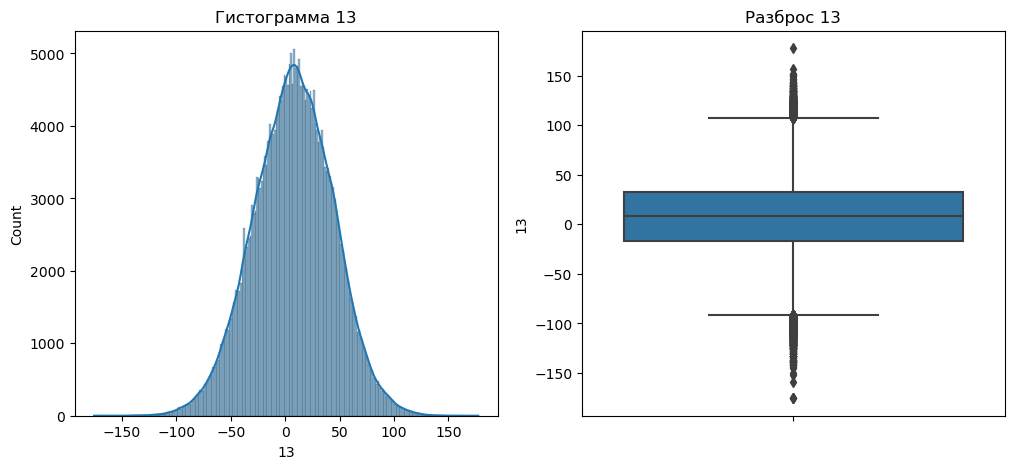

,count,mean,std,min,25%,50%,75%,max
13,291813.0,7.608319,36.576025,-175.62389,-16.890121,8.157776,32.713478,177.52704


Нижняя граница выбросов признака 13: -91.29551950000001
Верхняя граница выбросов признака 13: 107.1188765
Количество значений за нижней границей 13: 1245


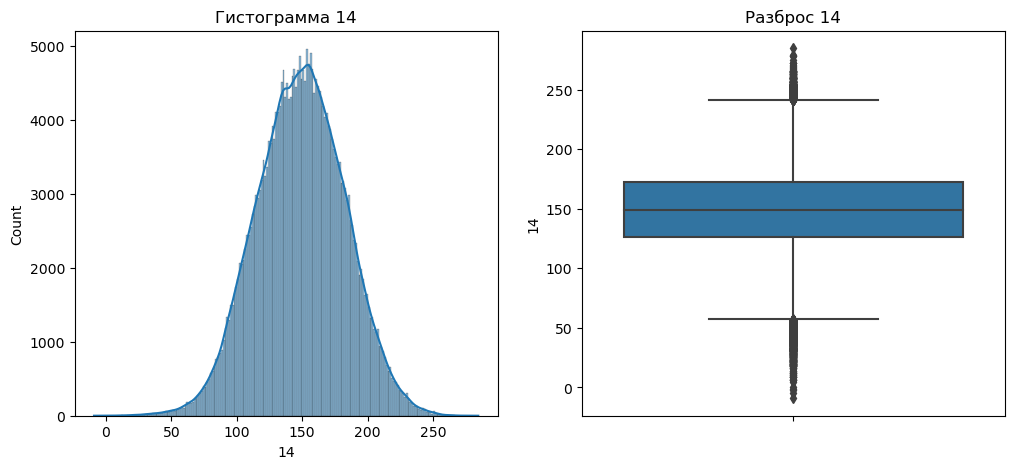

,count,mean,std,min,25%,50%,75%,max
14,291813.0,148.940275,33.623142,-9.157745,126.042564,149.2685,172.09314,284.65704


Нижняя граница выбросов признака 14: 56.96669999999999
Верхняя граница выбросов признака 14: 241.16900400000003
Количество значений за нижней границей 14: 1127


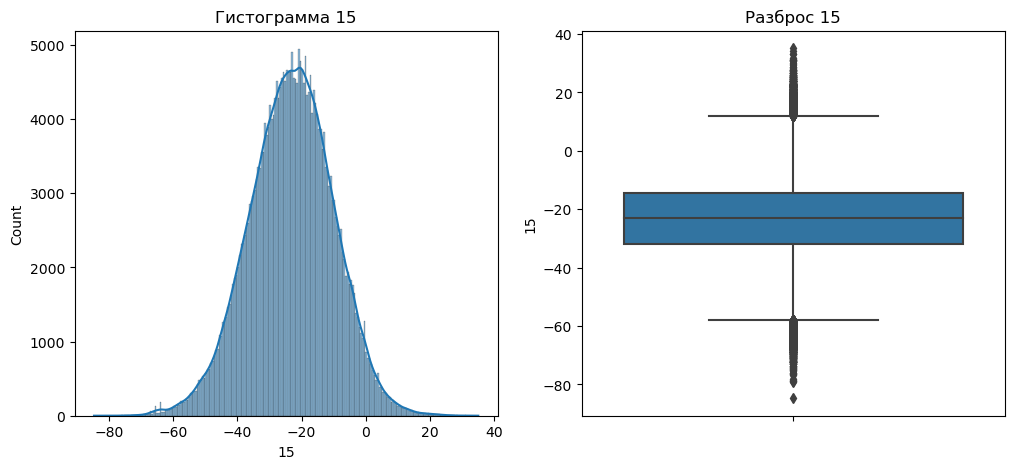

,count,mean,std,min,25%,50%,75%,max
15,291813.0,-23.195314,13.078519,-84.72425,-31.799664,-22.94325,-14.360533,35.08027


Нижняя граница выбросов признака 15: -57.9583605
Верхняя граница выбросов признака 15: 11.798163499999998
Количество значений за нижней границей 15: 1803


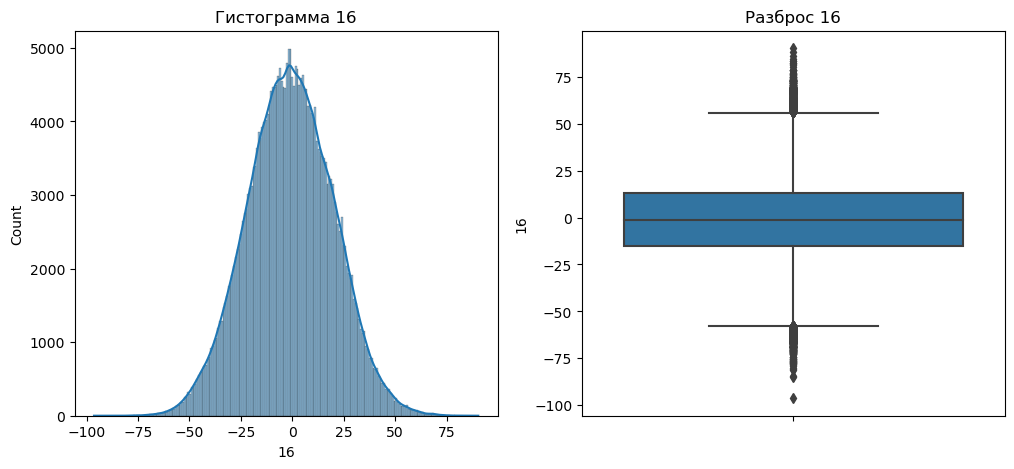

,count,mean,std,min,25%,50%,75%,max
16,291813.0,-0.939536,20.826134,-96.36816,-15.135077,-1.027163,13.355728,90.38921


Нижняя граница выбросов признака 16: -57.871283250000005
Верхняя граница выбросов признака 16: 56.09193475
Количество значений за нижней границей 16: 648


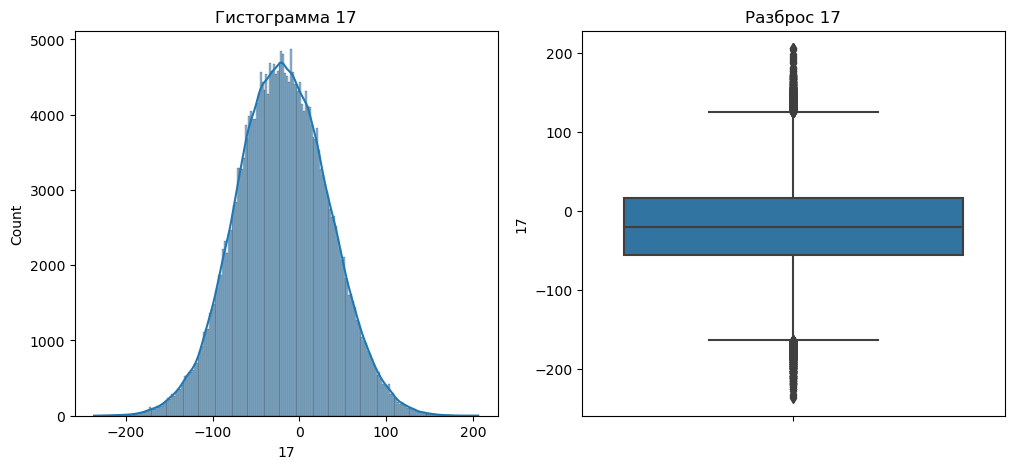

,count,mean,std,min,25%,50%,75%,max
17,291813.0,-19.230876,52.952607,-237.01878,-55.462906,-19.77864,16.777311,206.30397


Нижняя граница выбросов признака 17: -163.8232315
Верхняя граница выбросов признака 17: 125.1376365
Количество значений за нижней границей 17: 938


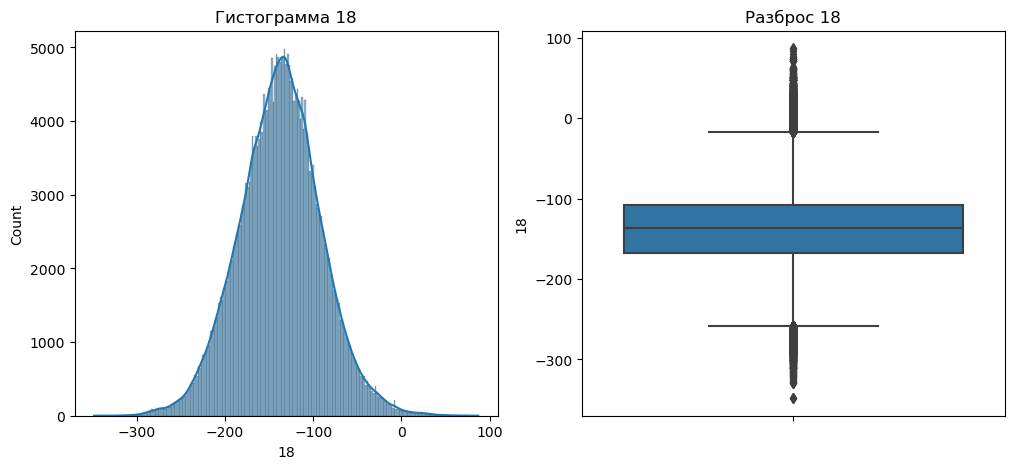

,count,mean,std,min,25%,50%,75%,max
18,291813.0,-137.380758,46.676018,-348.33624,-167.72423,-136.87704,-107.608,86.99808


Нижняя граница выбросов признака 18: -257.898575
Верхняя граница выбросов признака 18: -17.433655
Количество значений за нижней границей 18: 1881


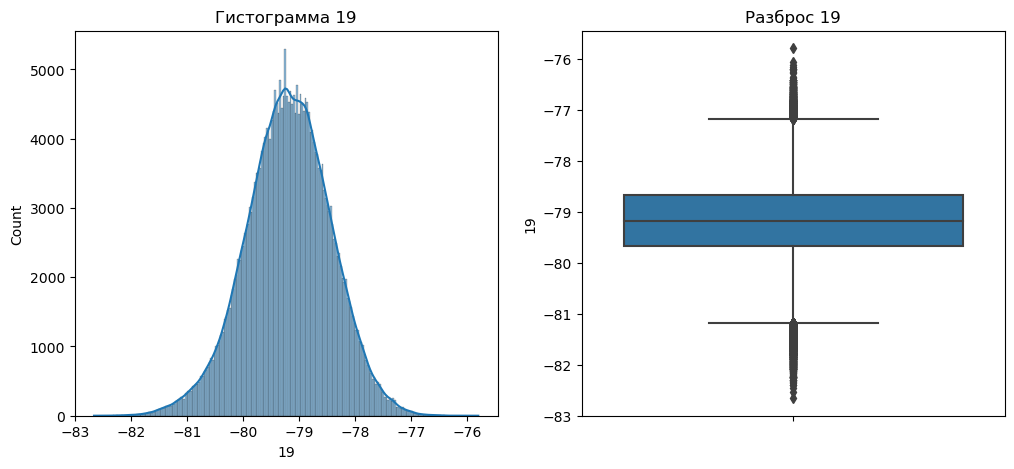

,count,mean,std,min,25%,50%,75%,max
19,291813.0,-79.189608,0.757619,-82.659546,-79.68022,-79.179794,-78.67911,-75.79646


Нижняя граница выбросов признака 19: -81.18188500000002
Верхняя граница выбросов признака 19: -77.17744499999998
Количество значений за нижней границей 19: 2185


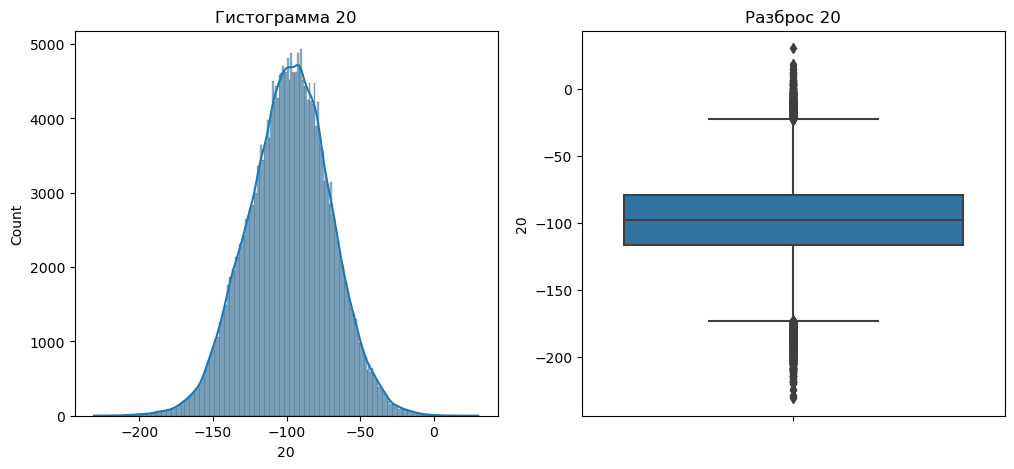

,count,mean,std,min,25%,50%,75%,max
20,291813.0,-98.276602,28.155715,-230.84027,-116.912186,-97.5362,-79.26724,30.247147


Нижняя граница выбросов признака 20: -173.37960500000003
Верхняя граница выбросов признака 20: -22.799820999999994
Количество значений за нижней границей 20: 1518


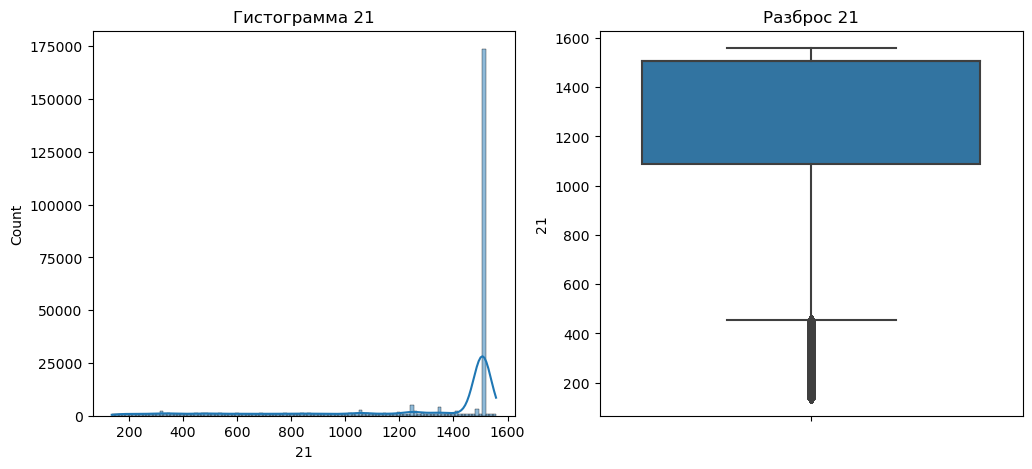

,count,mean,std,min,25%,50%,75%,max
21,291813.0,1257.119646,400.14014,136.855507,1086.24067,1507.231274,1507.231274,1557.41834


Нижняя граница выбросов признака 21: 454.7547634642177
Верхняя граница выбросов признака 21: 2138.7171806726374
Количество значений за нижней границей 21: 23785


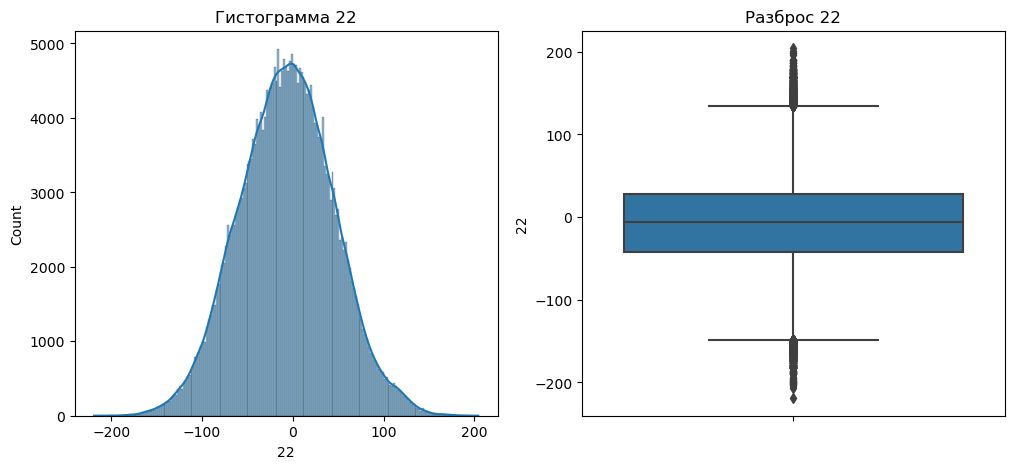

,count,mean,std,min,25%,50%,75%,max
22,291813.0,-6.817302,51.984937,-219.01587,-42.276604,-6.45683,28.285309,204.20126


Нижняя граница выбросов признака 22: -148.1194735
Верхняя граница выбросов признака 22: 134.12817850000002
Количество значений за нижней границей 22: 806


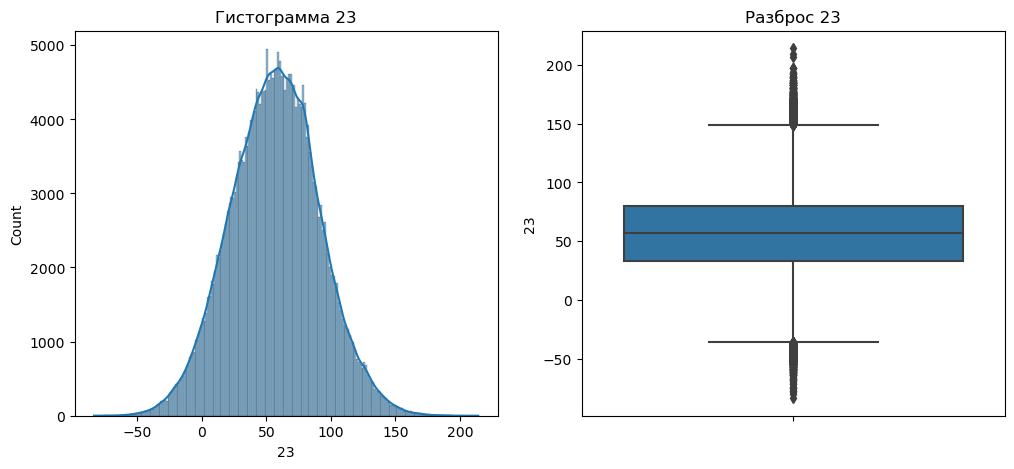

,count,mean,std,min,25%,50%,75%,max
23,291813.0,56.737918,34.382587,-83.70482,33.35194,57.078365,79.703354,214.31123


Нижняя граница выбросов признака 23: -36.17518100000001
Верхняя граница выбросов признака 23: 149.230475
Количество значений за нижней границей 23: 811


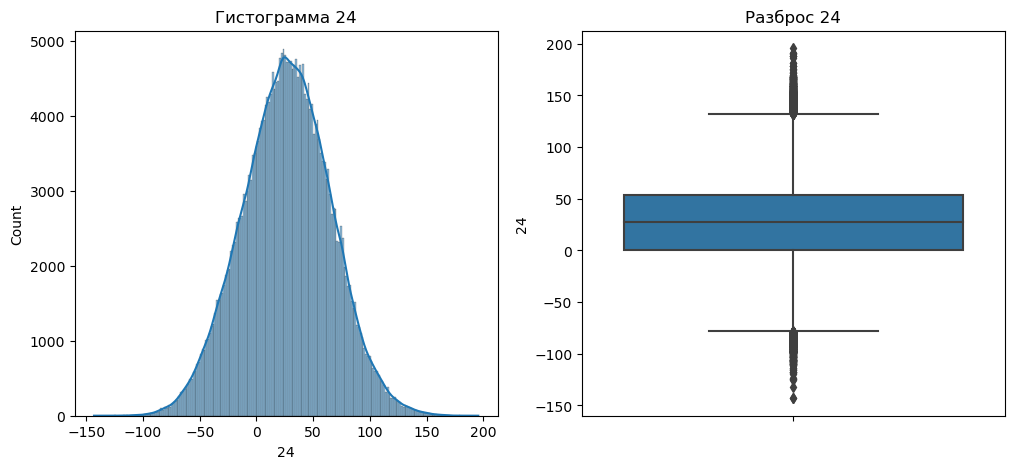

,count,mean,std,min,25%,50%,75%,max
24,291813.0,26.645141,38.963153,-143.18329,0.418633,27.024698,53.100124,195.51524


Нижняя граница выбросов признака 24: -78.60360475
Верхняя граница выбросов признака 24: 132.12236125
Количество значений за нижней границей 24: 812


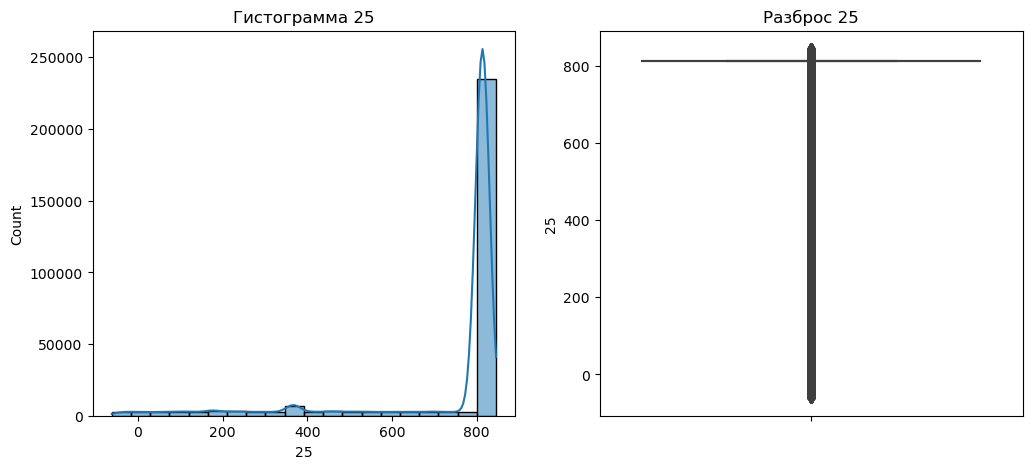

,count,mean,std,min,25%,50%,75%,max
25,291813.0,726.539553,206.009752,-61.967366,813.770071,813.770071,813.770071,845.758252


Нижняя граница выбросов признака 25: 813.7700714289165
Верхняя граница выбросов признака 25: 813.7700714289165
Количество значений за нижней границей 25: 57874


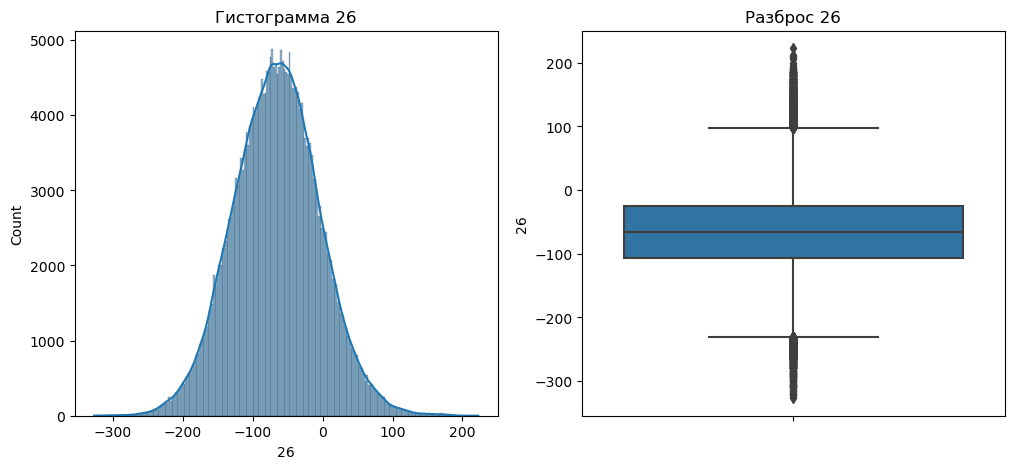

,count,mean,std,min,25%,50%,75%,max
26,291813.0,-65.999767,61.551614,-327.2262,-107.548615,-65.84709,-25.462177,222.61441


Нижняя граница выбросов признака 26: -230.678272
Верхняя граница выбросов признака 26: 97.66748000000001
Количество значений за нижней границей 26: 996


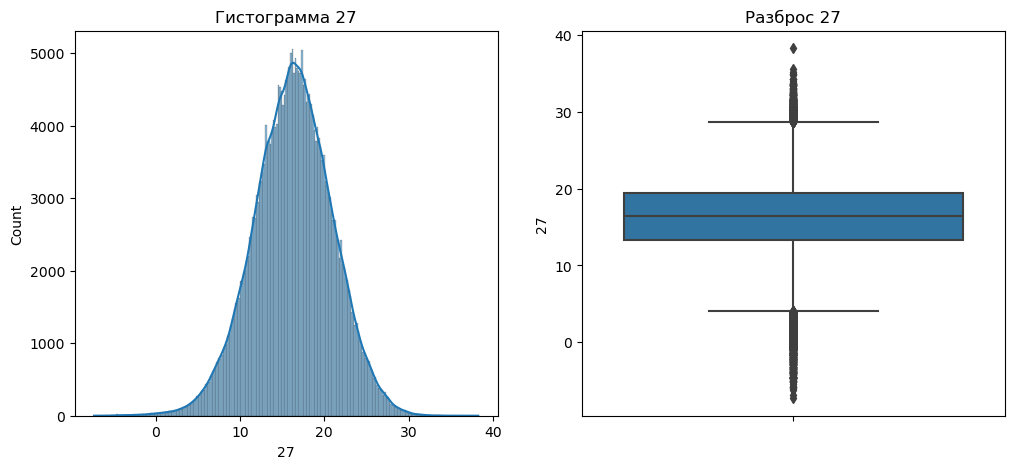

,count,mean,std,min,25%,50%,75%,max
27,291813.0,16.297703,4.657027,-7.296732,13.25052,16.361536,19.419718,38.26621


Нижняя граница выбросов признака 27: 3.996723000000001
Верхняя граница выбросов признака 27: 28.673515
Количество значений за нижней границей 27: 1909


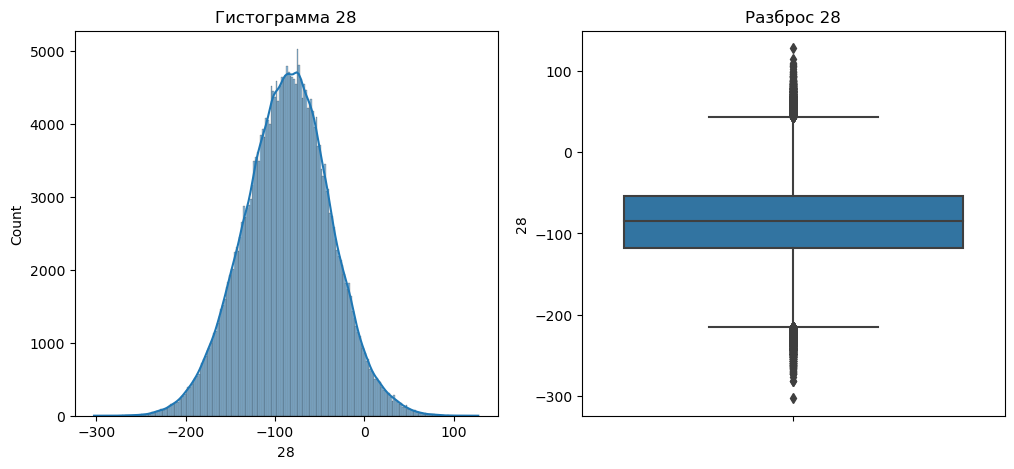

,count,mean,std,min,25%,50%,75%,max
28,291813.0,-86.279764,48.329281,-302.7724,-118.42065,-85.432304,-53.865955,127.49954


Нижняя граница выбросов признака 28: -215.2526925
Верхняя граница выбросов признака 28: 42.9660875
Количество значений за нижней границей 28: 1220


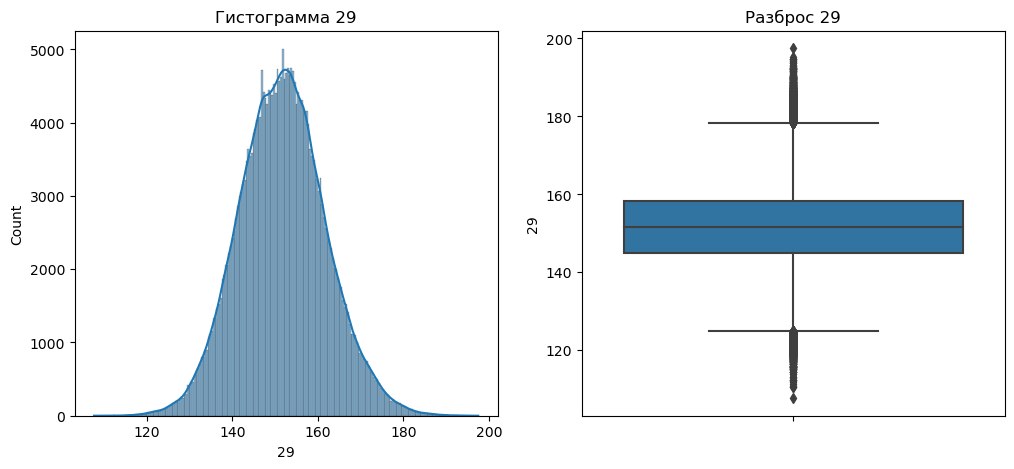

,count,mean,std,min,25%,50%,75%,max
29,291813.0,151.737398,10.093783,107.65045,144.89932,151.63626,158.27289,197.49994


Нижняя граница выбросов признака 29: 124.83896499999999
Верхняя граница выбросов признака 29: 178.33324499999998
Количество значений за нижней границей 29: 1014


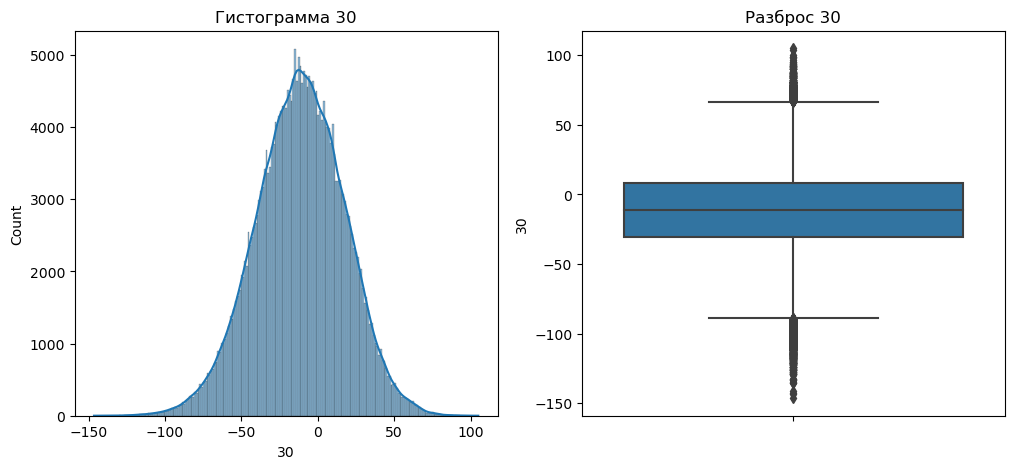

,count,mean,std,min,25%,50%,75%,max
30,291813.0,-11.569343,28.934056,-146.49542,-30.690517,-11.121221,8.277879,105.03669


Нижняя граница выбросов признака 30: -89.143111
Верхняя граница выбросов признака 30: 66.730473
Количество значений за нижней границей 30: 1550


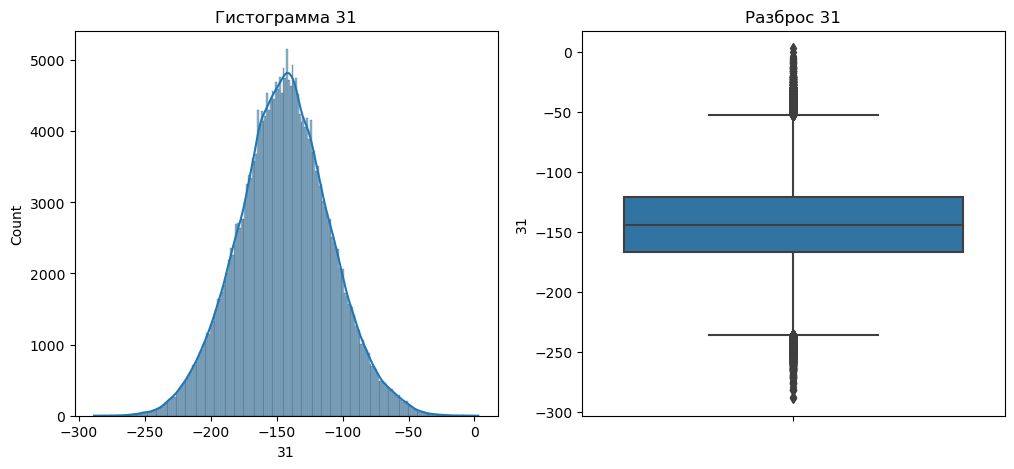

,count,mean,std,min,25%,50%,75%,max
31,291813.0,-144.233906,34.905297,-288.61398,-167.12332,-144.20212,-121.31772,2.917328


Нижняя граница выбросов признака 31: -235.83172000000002
Верхняя граница выбросов признака 31: -52.60931999999998
Количество значений за нижней границей 31: 1120


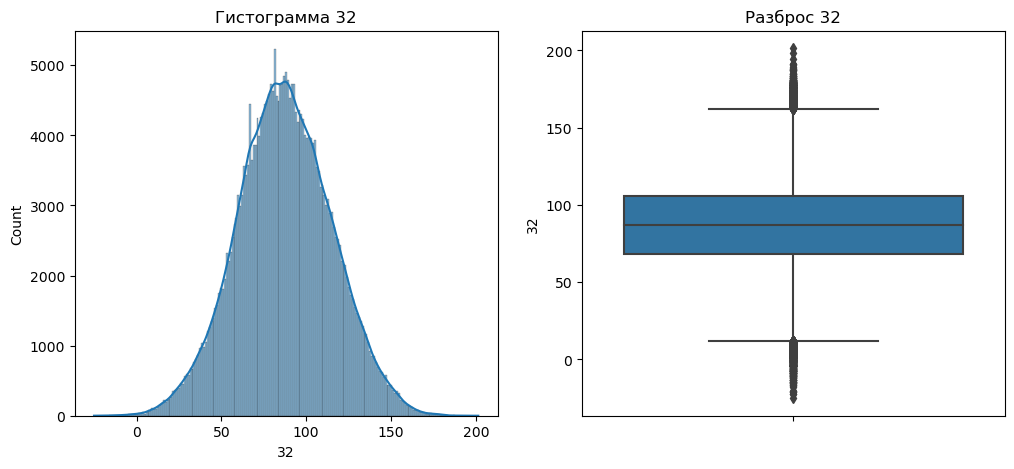

,count,mean,std,min,25%,50%,75%,max
32,291813.0,87.271323,27.781245,-25.102974,68.43813,86.89789,105.96528,201.42862


Нижняя граница выбросов признака 32: 12.147404999999992
Верхняя граница выбросов признака 32: 162.25600500000002
Количество значений за нижней границей 32: 852


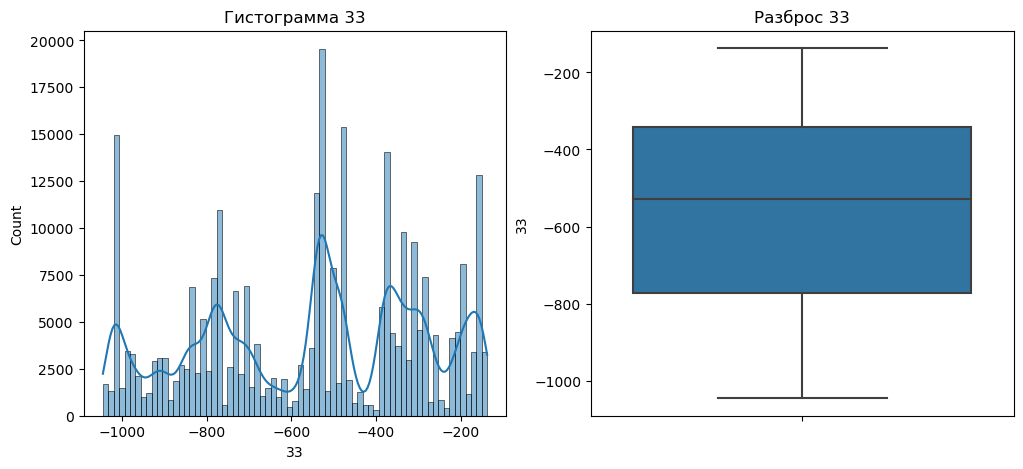

,count,mean,std,min,25%,50%,75%,max
33,291813.0,-555.030333,260.728908,-1045.311529,-771.296708,-529.295053,-341.781842,-137.646757


Нижняя граница выбросов признака 33: -1415.5690055064426
Верхняя граница выбросов признака 33: 302.49045544547374
Количество значений за нижней границей 33: 0


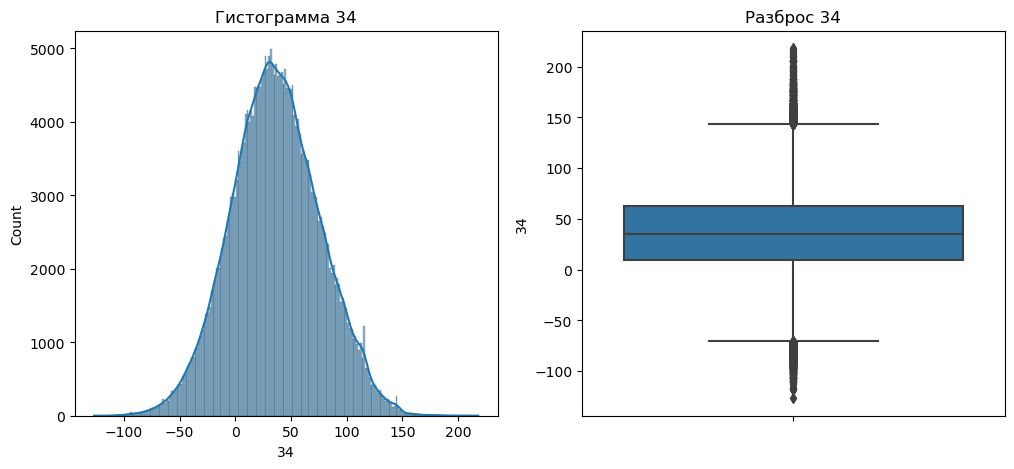

,count,mean,std,min,25%,50%,75%,max
34,291813.0,36.354556,39.894835,-126.765594,9.4545,35.47712,62.98905,218.161


Нижняя граница выбросов признака 34: -70.847325
Верхняя граница выбросов признака 34: 143.290875
Количество значений за нижней границей 34: 953


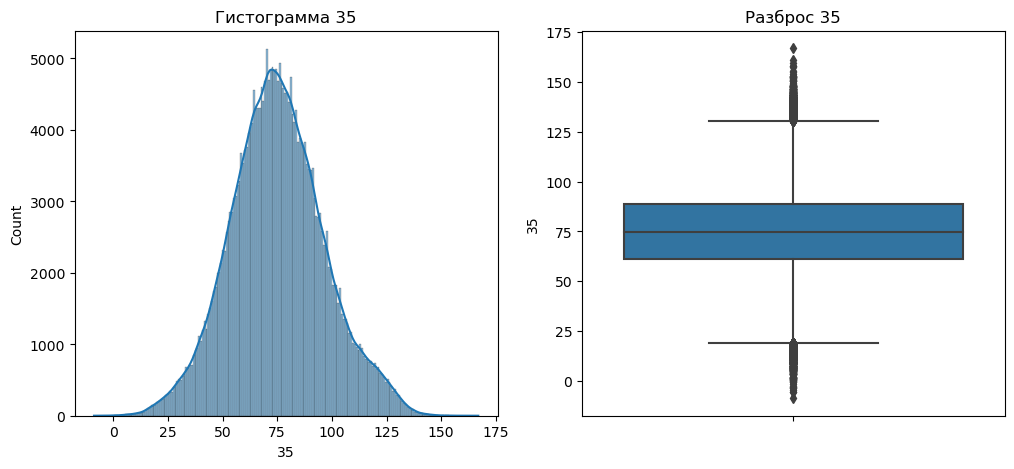

,count,mean,std,min,25%,50%,75%,max
35,291813.0,75.165481,21.457381,-8.800842,60.934887,74.53354,88.79018,166.94849


Нижняя граница выбросов признака 35: 19.1519475
Верхняя граница выбросов признака 35: 130.57311950000002
Количество значений за нижней границей 35: 1048


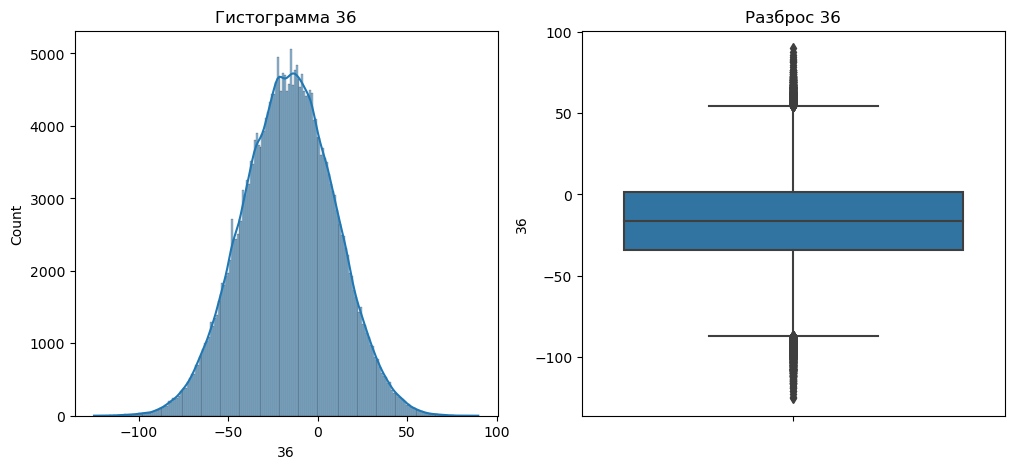

,count,mean,std,min,25%,50%,75%,max
36,291813.0,-16.450743,25.832185,-125.22654,-34.11769,-16.169163,1.232896,89.750755


Нижняя граница выбросов признака 36: -87.14356885000001
Верхняя граница выбросов признака 36: 54.258774750000015
Количество значений за нижней границей 36: 875


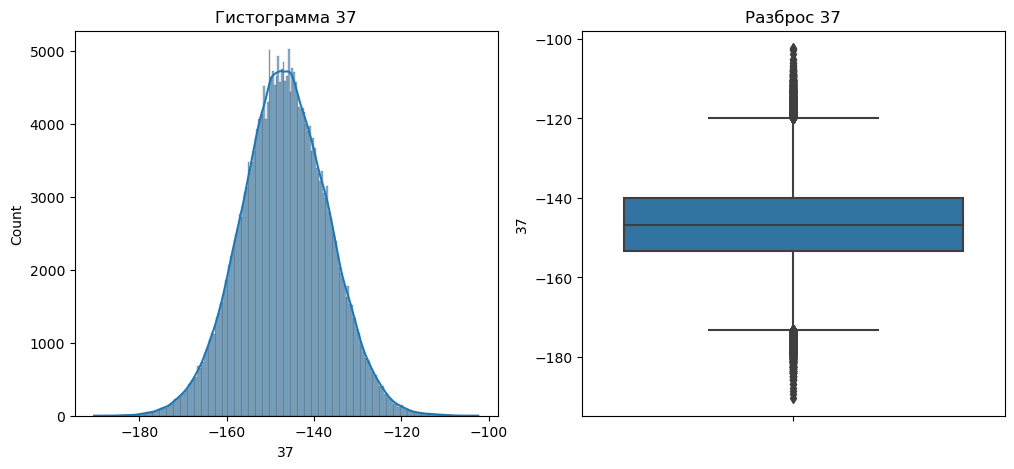

,count,mean,std,min,25%,50%,75%,max
37,291813.0,-146.667125,9.952702,-190.38599,-153.28656,-146.7503,-139.97229,-102.34189


Нижняя граница выбросов признака 37: -173.25796500000004
Верхняя граница выбросов признака 37: -120.00088499999995
Количество значений за нижней границей 37: 1226


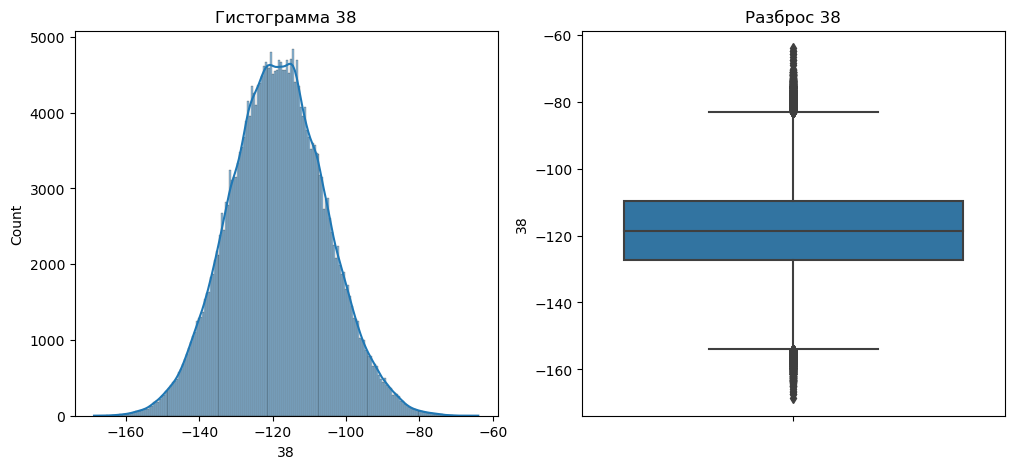

,count,mean,std,min,25%,50%,75%,max
38,291813.0,-118.525117,13.12544,-168.63742,-127.44354,-118.587715,-109.69608,-63.957638


Нижняя граница выбросов признака 38: -154.06473
Верхняя граница выбросов признака 38: -83.07488999999998
Количество значений за нижней границей 38: 725


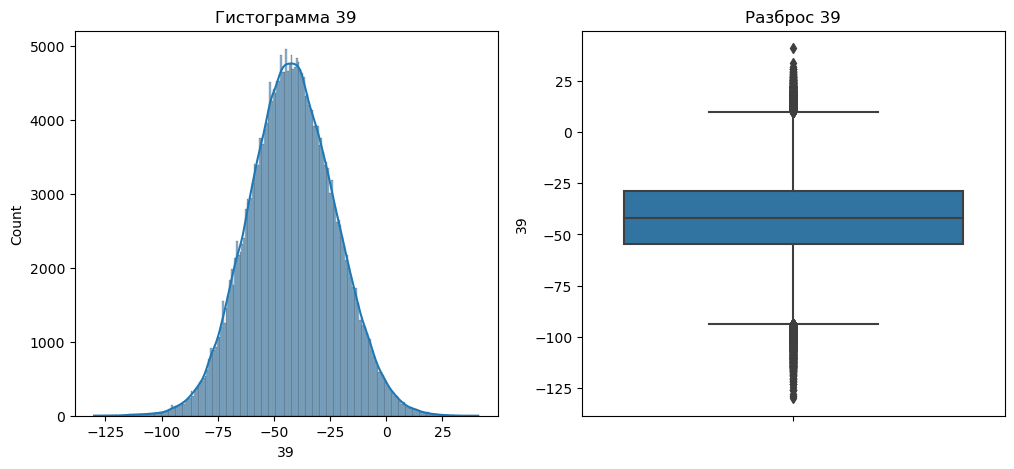

,count,mean,std,min,25%,50%,75%,max
39,291813.0,-41.902869,19.208804,-130.04404,-54.86808,-42.066116,-28.954714,40.95566


Нижняя граница выбросов признака 39: -93.738129
Верхняя граница выбросов признака 39: 9.915335000000002
Количество значений за нижней границей 39: 1116


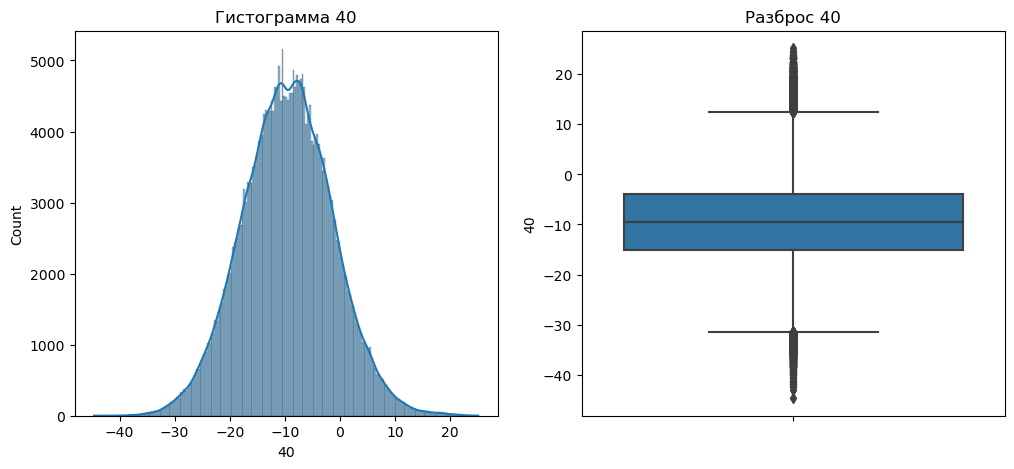

,count,mean,std,min,25%,50%,75%,max
40,291813.0,-9.505951,8.18848,-44.640232,-15.000622,-9.496562,-4.023318,25.123966


Нижняя граница выбросов признака 40: -31.46657755
Верхняя граница выбросов признака 40: 12.44263725
Количество значений за нижней границей 40: 941


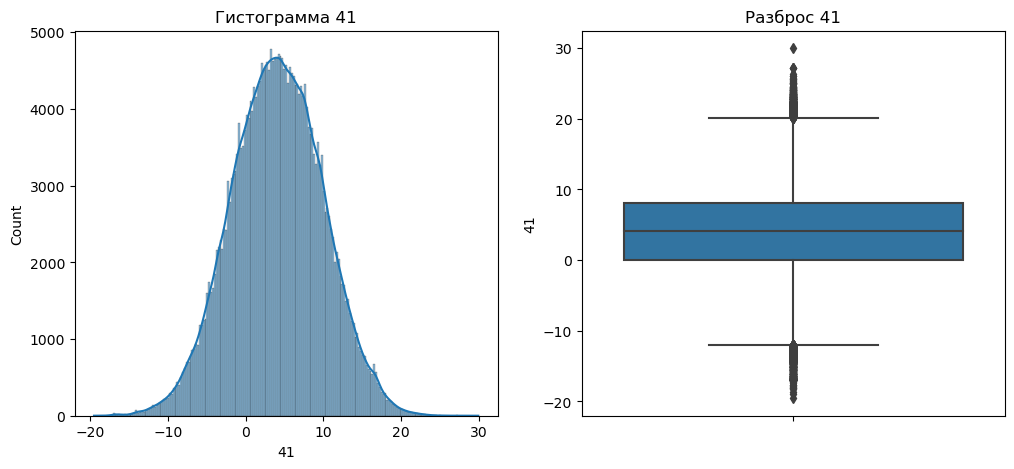

,count,mean,std,min,25%,50%,75%,max
41,291813.0,4.069182,5.829764,-19.545673,0.062776,4.082789,8.083019,29.969437


Нижняя граница выбросов признака 41: -11.967589475000002
Верхняя граница выбросов признака 41: 20.113384085
Количество значений за нижней границей 41: 894


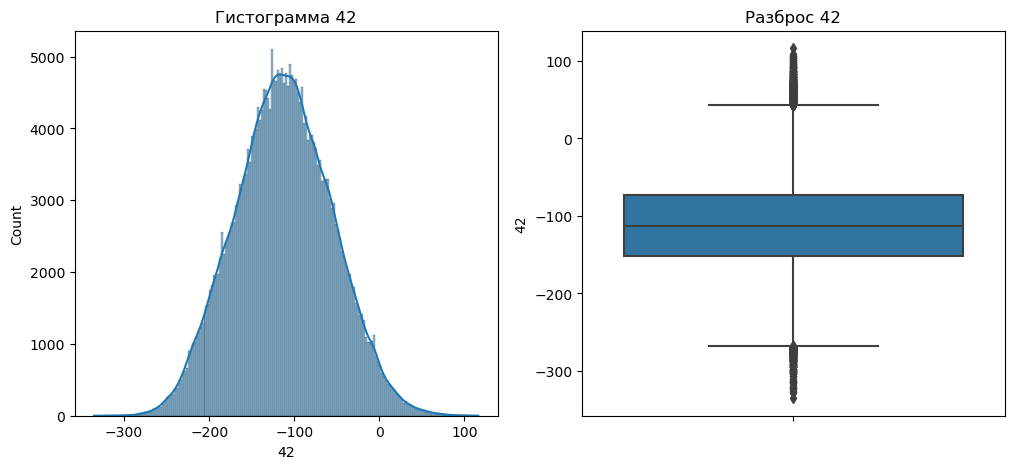

,count,mean,std,min,25%,50%,75%,max
42,291813.0,-112.666843,56.950392,-335.37622,-151.58891,-112.99476,-73.767555,116.25995


Нижняя граница выбросов признака 42: -268.3209425
Верхняя граница выбросов признака 42: 42.9644775
Количество значений за нижней границей 42: 364


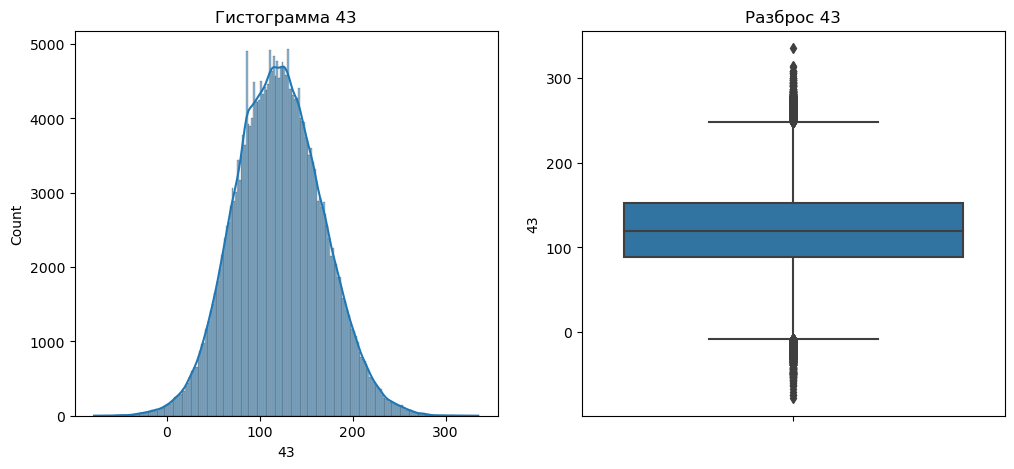

,count,mean,std,min,25%,50%,75%,max
43,291813.0,120.820683,46.780878,-78.07732,88.17501,119.890175,152.20813,335.19873


Нижняя граница выбросов признака 43: -7.874670000000023
Верхняя граница выбросов признака 43: 248.25781000000003
Количество значений за нижней границей 43: 800


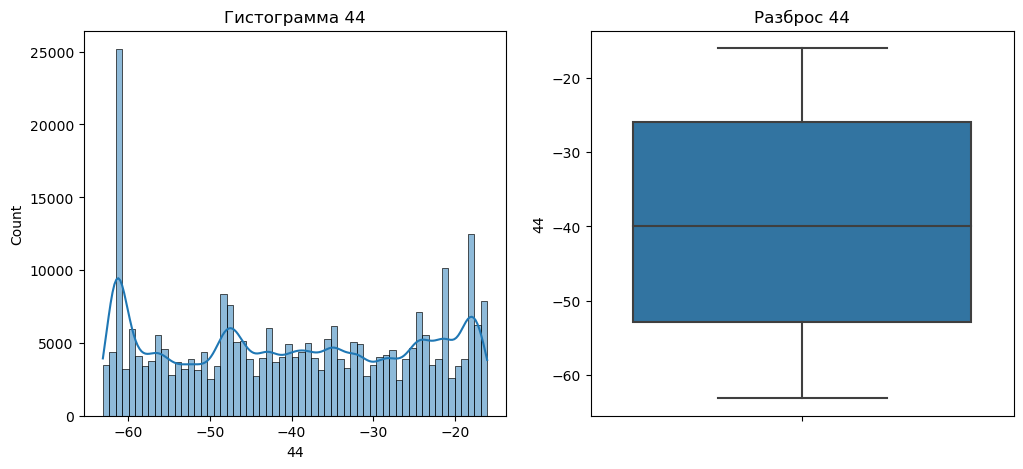

,count,mean,std,min,25%,50%,75%,max
44,291813.0,-39.78857,14.735848,-63.102401,-52.853639,-39.989435,-25.981533,-16.052626


Нижняя граница выбросов признака 44: -93.16179837744677
Верхняя граница выбросов признака 44: 14.326626766424798
Количество значений за нижней границей 44: 0


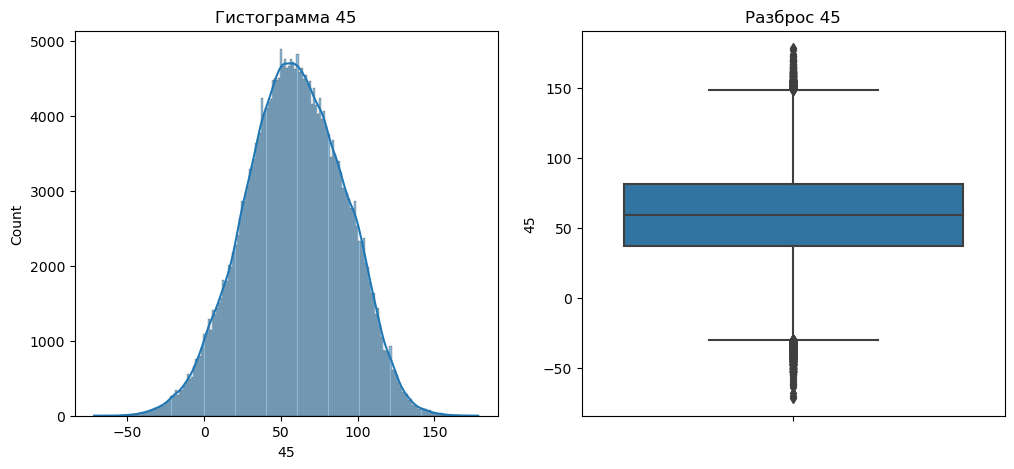

,count,mean,std,min,25%,50%,75%,max
45,291813.0,58.962295,32.027228,-71.691635,37.099083,59.02042,81.842316,178.59961


Нижняя граница выбросов признака 45: -30.01576649999999
Верхняя граница выбросов признака 45: 148.95716549999997
Количество значений за нижней границей 45: 710


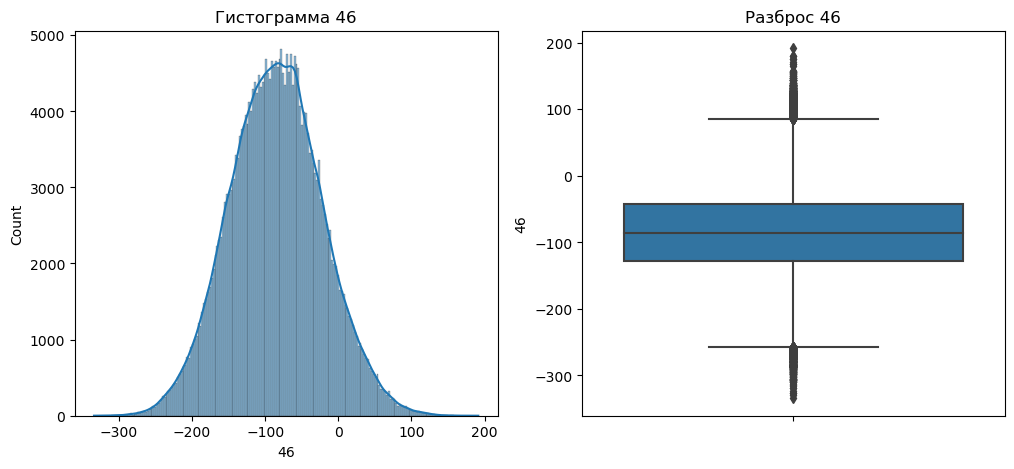

,count,mean,std,min,25%,50%,75%,max
46,291813.0,-85.102851,63.2652,-334.21375,-128.60083,-85.374435,-43.052475,191.47229


Нижняя граница выбросов признака 46: -256.9233625
Верхняя граница выбросов признака 46: 85.2700575
Количество значений за нижней границей 46: 598


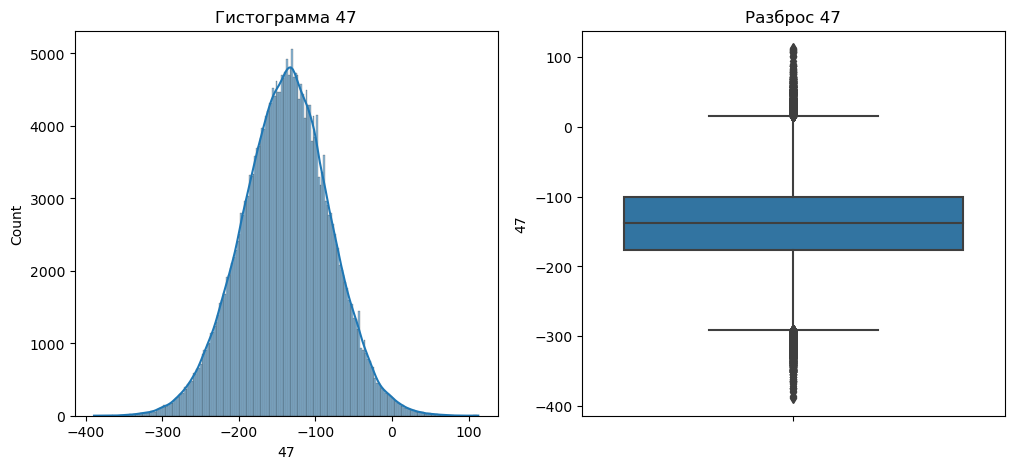

,count,mean,std,min,25%,50%,75%,max
47,291813.0,-138.542656,57.718288,-389.02664,-176.60126,-137.50801,-100.04849,112.6362


Нижняя граница выбросов признака 47: -291.430415
Верхняя граница выбросов признака 47: 14.780664999999985
Количество значений за нижней границей 47: 1476


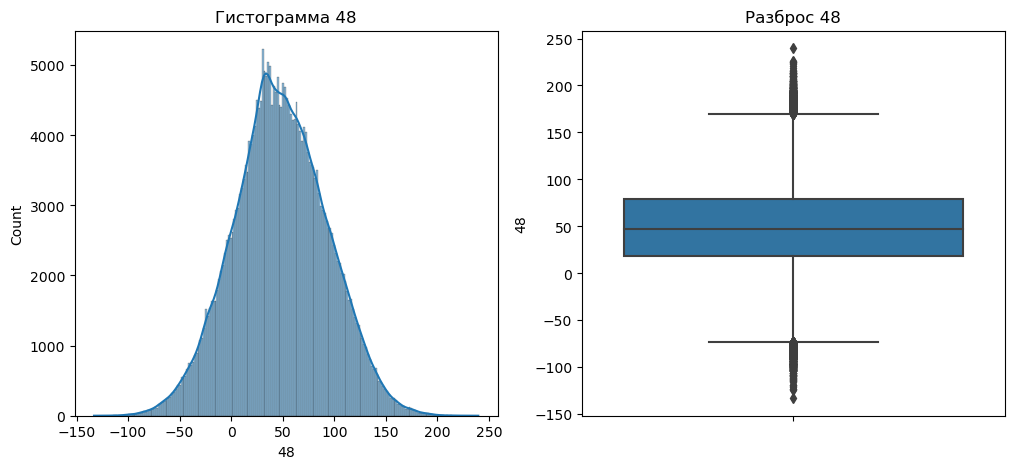

,count,mean,std,min,25%,50%,75%,max
48,291813.0,47.962621,45.199092,-133.09203,17.886696,46.95818,78.64165,239.68379


Нижняя граница выбросов признака 48: -73.245735
Верхняя граница выбросов признака 48: 169.774081
Количество значений за нижней границей 48: 855


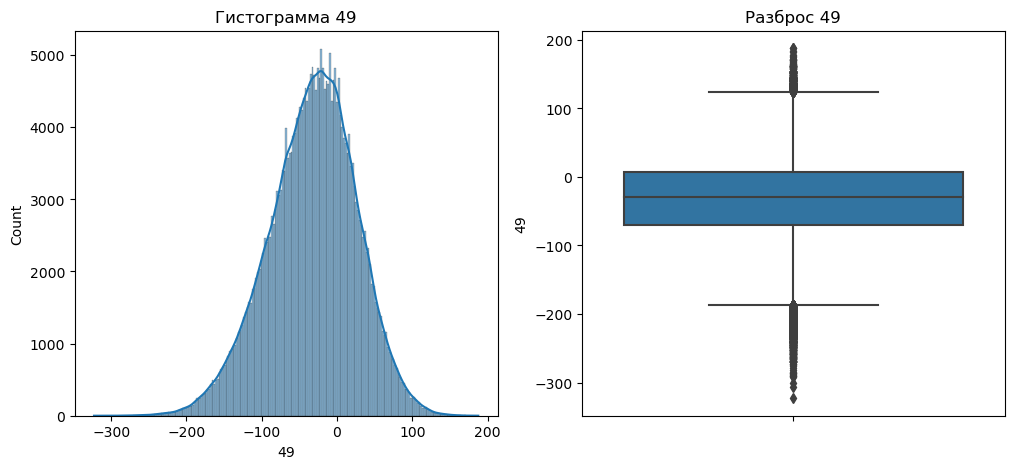

,count,mean,std,min,25%,50%,75%,max
49,291813.0,-32.597303,58.254867,-322.81207,-70.01322,-29.367325,7.430988,187.69379


Нижняя граница выбросов признака 49: -186.17953245
Верхняя граница выбросов признака 49: 123.59730074999999
Количество значений за нижней границей 49: 2026


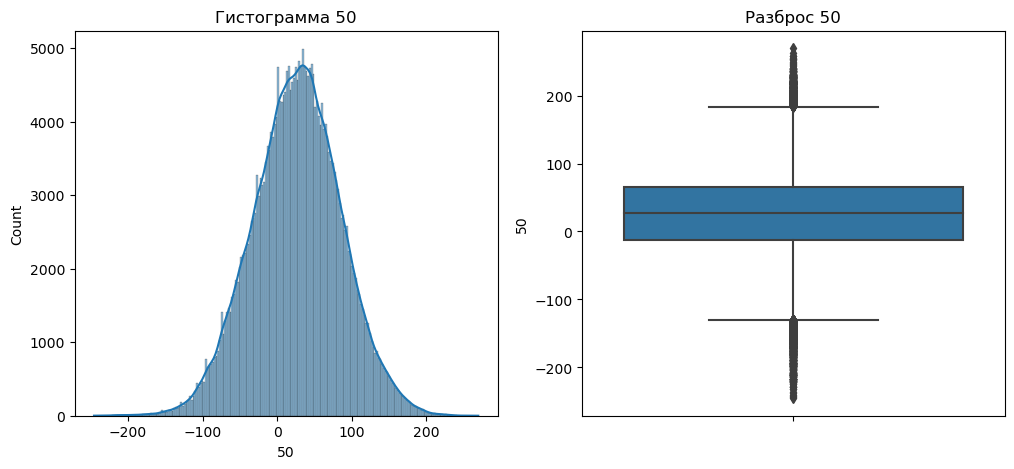

,count,mean,std,min,25%,50%,75%,max
50,291813.0,26.591666,59.066918,-245.63503,-12.432201,27.534252,66.12746,269.81522


Нижняя граница выбросов признака 50: -130.2716925
Верхняя граница выбросов признака 50: 183.9669515
Количество значений за нижней границей 50: 1320


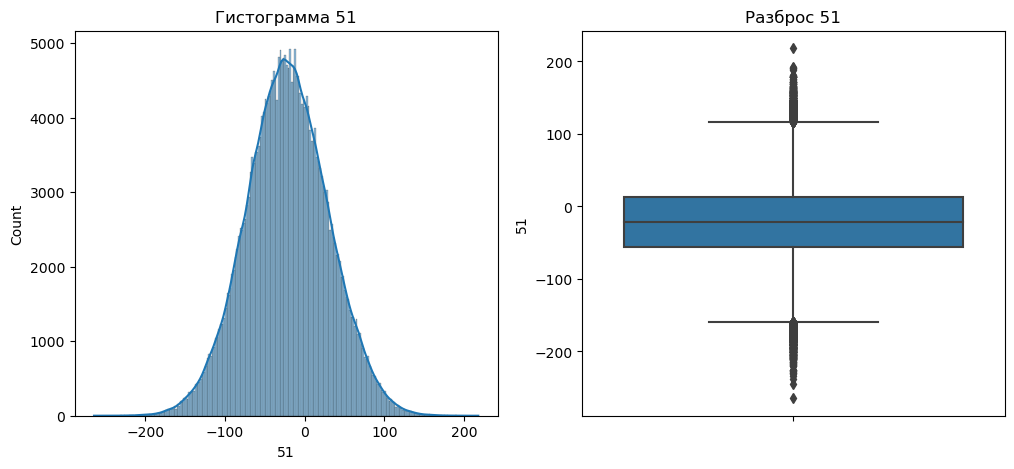

,count,mean,std,min,25%,50%,75%,max
51,291813.0,-21.808728,51.778506,-264.63345,-56.35727,-22.228325,12.686851,217.98927


Нижняя граница выбросов признака 51: -159.92345225
Верхняя граница выбросов признака 51: 116.25303375
Количество значений за нижней границей 51: 1129


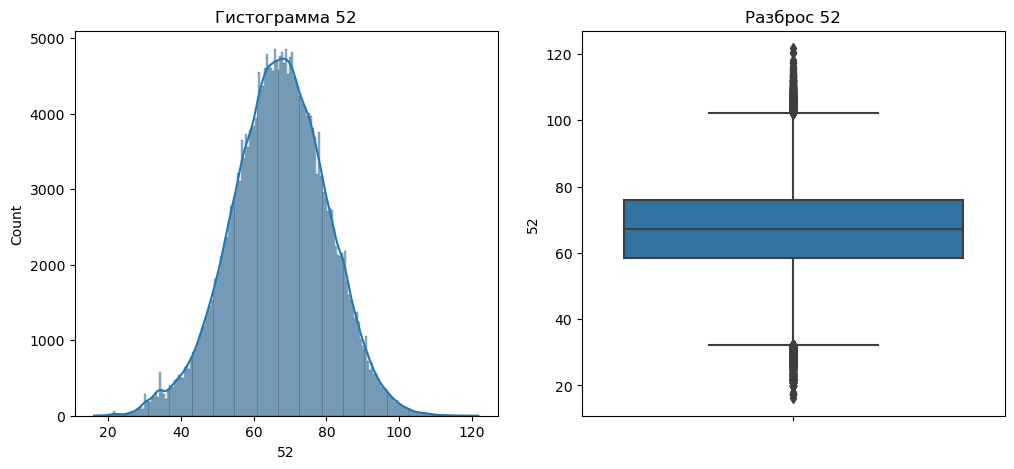

,count,mean,std,min,25%,50%,75%,max
52,291813.0,67.03307,13.06357,16.126598,58.475163,67.248245,75.94993,121.719666


Нижняя граница выбросов признака 52: 32.263012500000016
Верхняя граница выбросов признака 52: 102.16208049999999
Количество значений за нижней границей 52: 1804


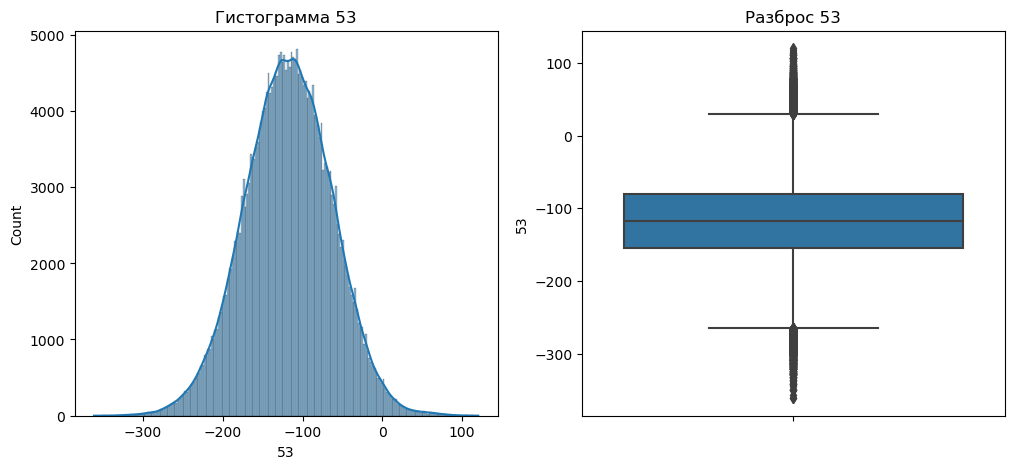

,count,mean,std,min,25%,50%,75%,max
53,291813.0,-117.973309,54.774973,-361.48935,-154.60501,-117.65785,-80.78255,120.15059


Нижняя граница выбросов признака 53: -265.3387
Верхняя граница выбросов признака 53: 29.951139999999995
Количество значений за нижней границей 53: 1280


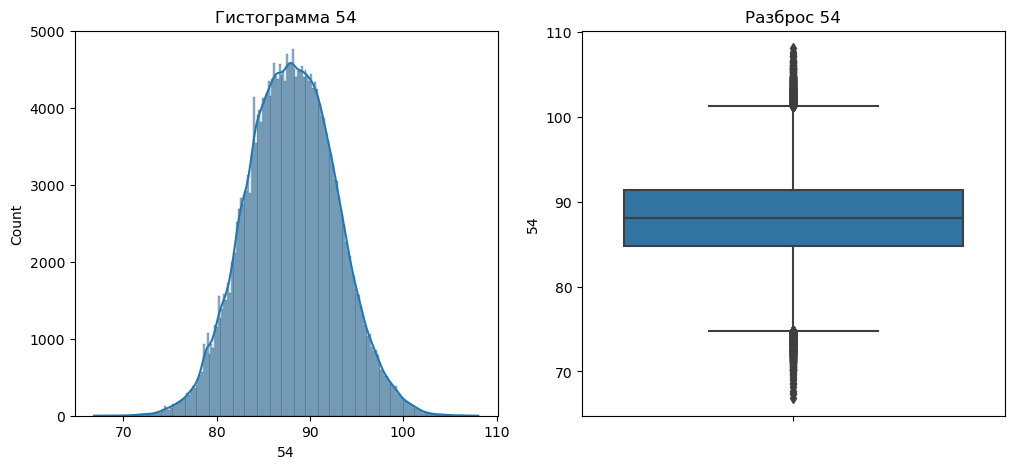

,count,mean,std,min,25%,50%,75%,max
54,291813.0,88.033431,4.773332,66.85103,84.71442,88.016914,91.311714,108.044174


Нижняя граница выбросов признака 54: 74.81847900000002
Верхняя граница выбросов признака 54: 101.20765499999999
Количество значений за нижней границей 54: 740


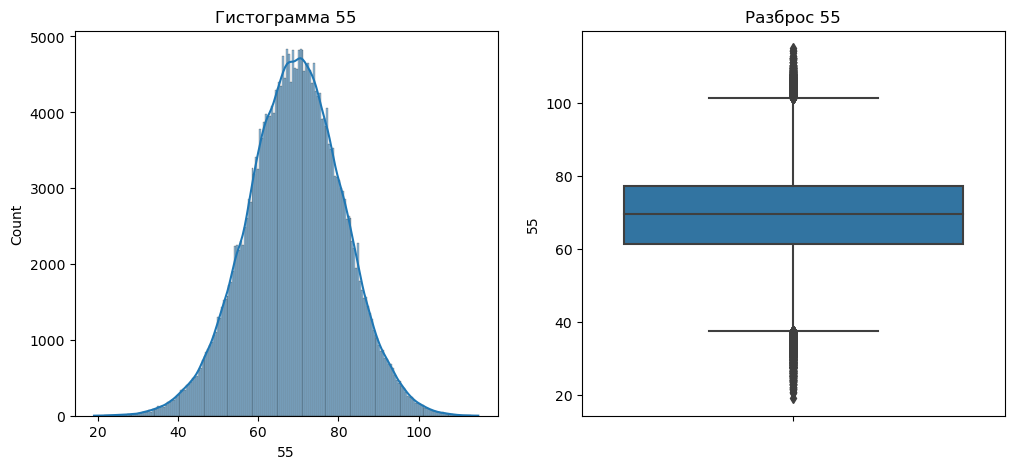

,count,mean,std,min,25%,50%,75%,max
55,291813.0,69.206822,11.955396,18.996754,61.307587,69.34352,77.2622,114.881516


Нижняя граница выбросов признака 55: 37.375667499999984
Верхняя граница выбросов признака 55: 101.19411950000003
Количество значений за нижней границей 55: 1548


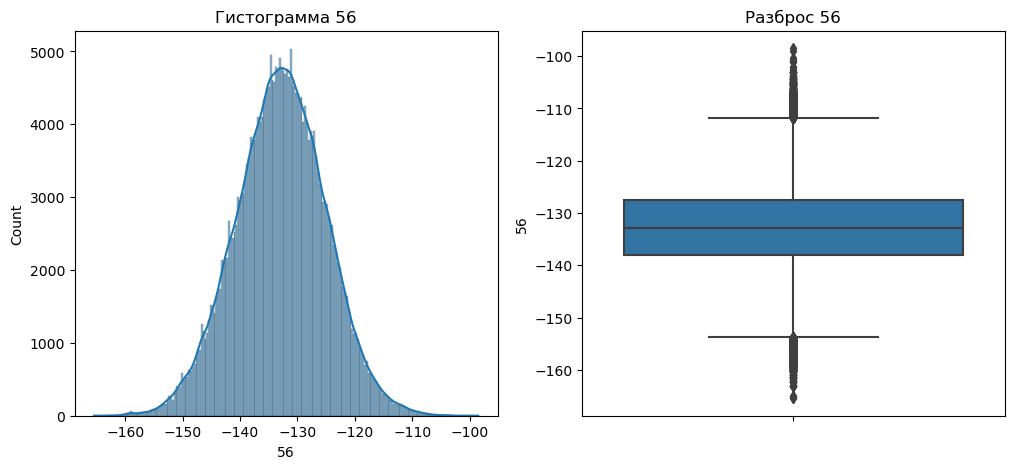

,count,mean,std,min,25%,50%,75%,max
56,291813.0,-132.89161,7.820257,-165.42142,-138.08162,-132.80913,-127.6131,-98.52727


Нижняя граница выбросов признака 56: -153.78439999999995
Верхняя граница выбросов признака 56: -111.91032000000003
Количество значений за нижней границей 56: 1145


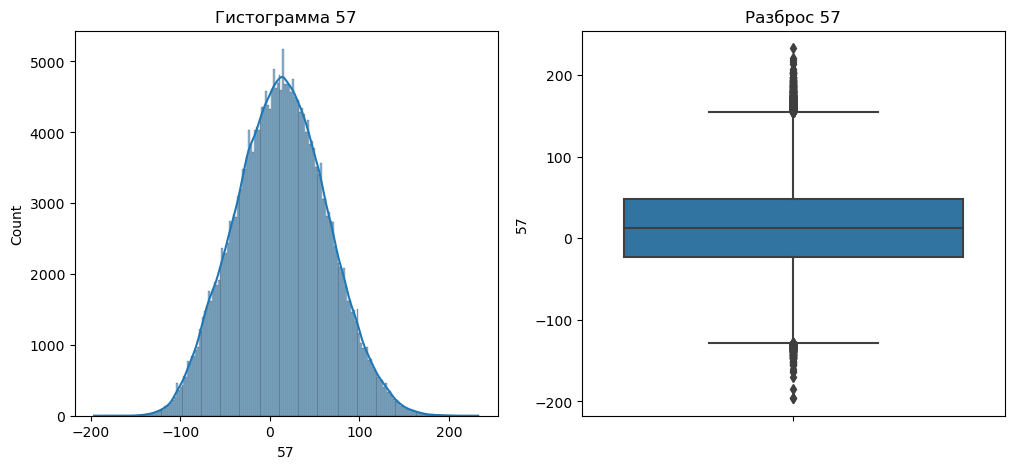

,count,mean,std,min,25%,50%,75%,max
57,291813.0,13.104575,51.070116,-196.18361,-22.556282,13.010898,48.060093,232.70775


Нижняя граница выбросов признака 57: -128.48084450000002
Верхняя граница выбросов признака 57: 153.9846555
Количество значений за нижней границей 57: 188


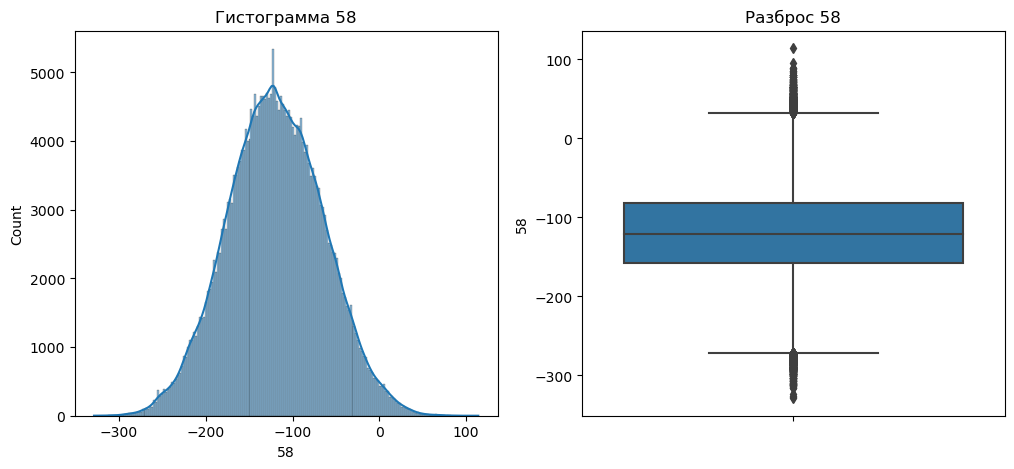

,count,mean,std,min,25%,50%,75%,max
58,291813.0,-119.628076,55.163448,-328.82928,-157.46606,-120.447365,-81.760864,113.96736


Нижняя граница выбросов признака 58: -271.02385400000003
Верхняя граница выбросов признака 58: 31.796930000000003
Количество значений за нижней границей 58: 528


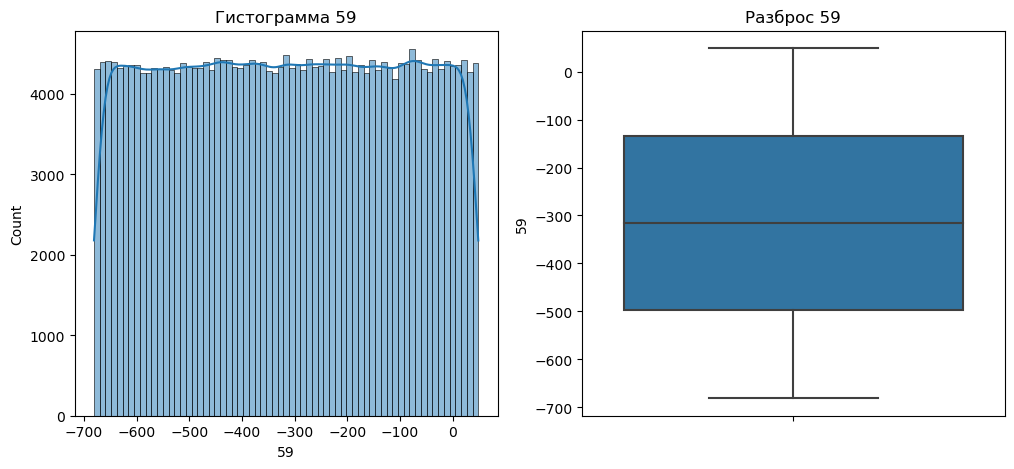

,count,mean,std,min,25%,50%,75%,max
59,291813.0,-315.824414,210.631518,-681.042024,-497.719259,-315.599024,-133.386267,48.727576


Нижняя граница выбросов признака 59: -1044.2187468644927
Верхняя граница выбросов признака 59: 413.113220278869
Количество значений за нижней границей 59: 0


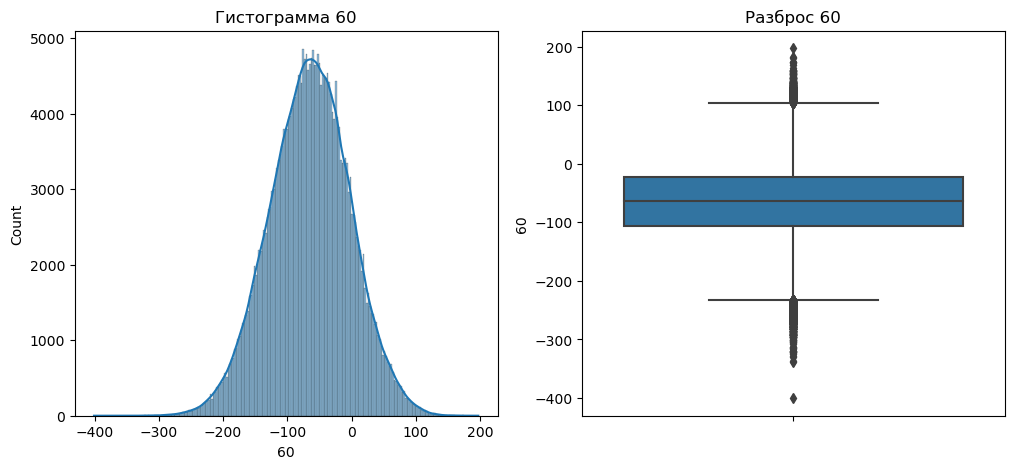

,count,mean,std,min,25%,50%,75%,max
60,291813.0,-64.894401,62.525113,-400.7911,-106.7102,-63.76503,-22.567879,197.2797


Нижняя граница выбросов признака 60: -232.9236815
Верхняя граница выбросов признака 60: 103.6456025
Количество значений за нижней границей 60: 1193


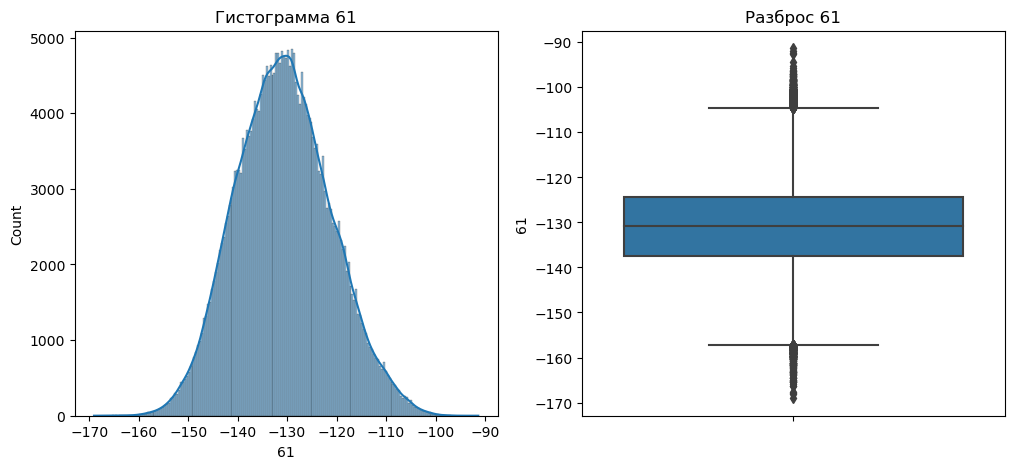

,count,mean,std,min,25%,50%,75%,max
61,291813.0,-130.688468,9.573147,-169.02837,-137.43016,-130.91283,-124.29818,-91.366425


Нижняя граница выбросов признака 61: -157.12813
Верхняя граница выбросов признака 61: -104.60021
Количество значений за нижней границей 61: 303


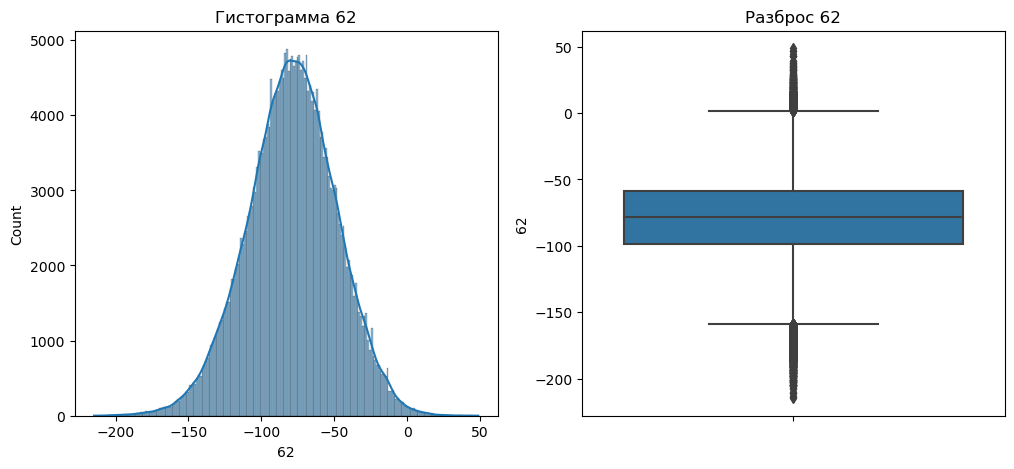

,count,mean,std,min,25%,50%,75%,max
62,291813.0,-79.075207,30.485074,-214.82114,-98.82383,-78.53818,-58.638412,48.822197


Нижняя граница выбросов признака 62: -159.101957
Верхняя граница выбросов признака 62: 1.6397149999999954
Количество значений за нижней границей 62: 1887


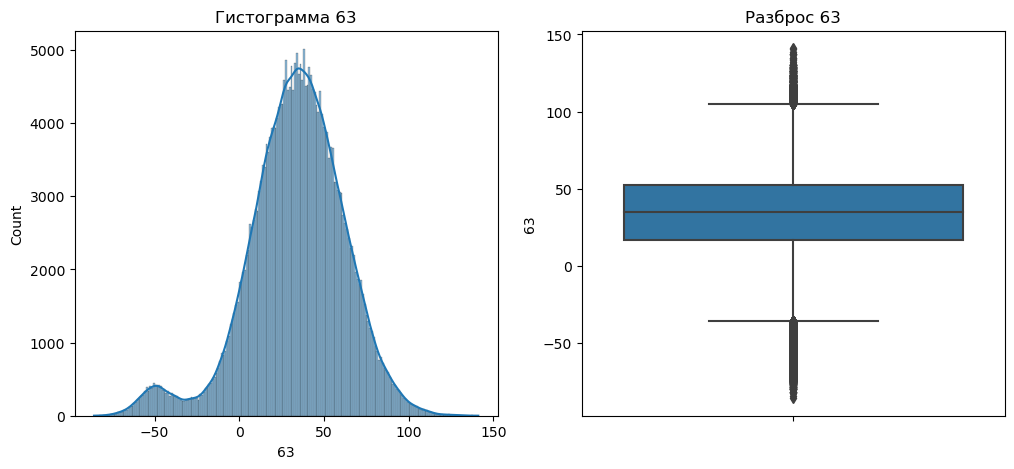

,count,mean,std,min,25%,50%,75%,max
63,291813.0,33.244836,28.896144,-85.8255,16.952824,34.68254,52.09771,141.02527


Нижняя граница выбросов признака 63: -35.764505
Верхняя граница выбросов признака 63: 104.815039
Количество значений за нижней границей 63: 9121


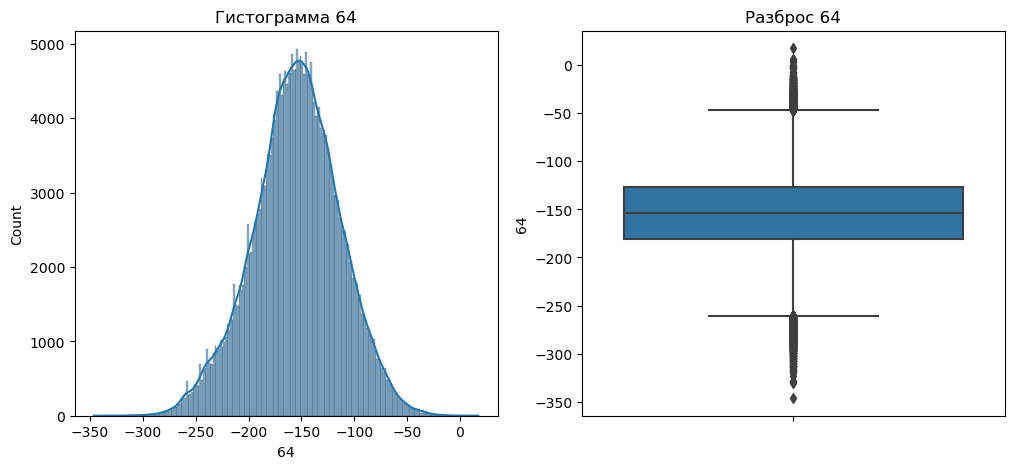

,count,mean,std,min,25%,50%,75%,max
64,291813.0,-154.720293,41.217568,-346.23932,-180.69556,-153.90283,-127.22136,17.344528


Нижняя граница выбросов признака 64: -260.90686
Верхняя граница выбросов признака 64: -47.01006000000001
Количество значений за нижней границей 64: 1876


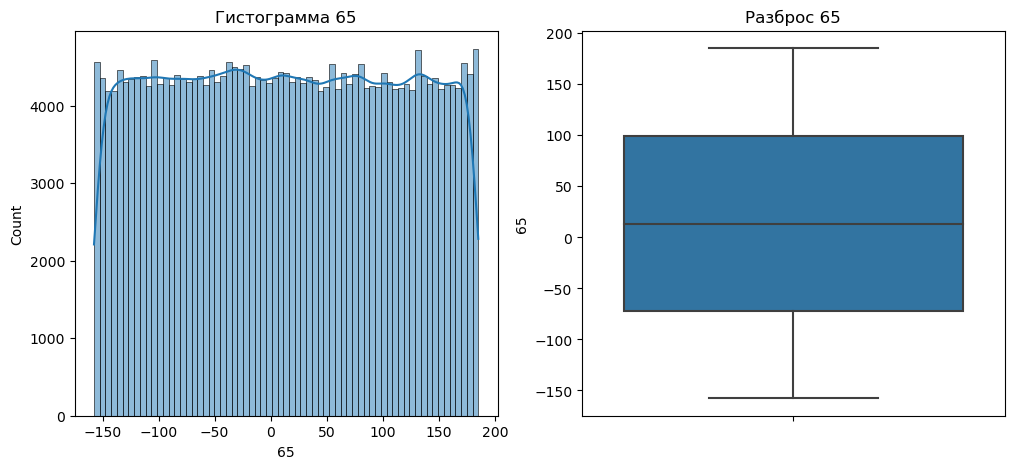

,count,mean,std,min,25%,50%,75%,max
65,291813.0,13.699277,98.996416,-157.593866,-71.763964,13.167371,99.362213,185.096719


Нижняя граница выбросов признака 65: -328.45322900936816
Верхняя граница выбросов признака 65: 356.0514778726506
Количество значений за нижней границей 65: 0


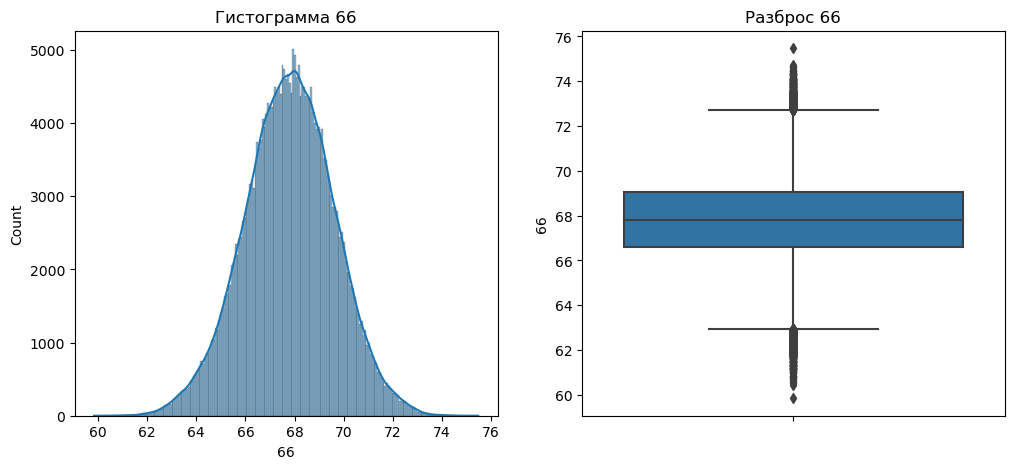

,count,mean,std,min,25%,50%,75%,max
66,291813.0,67.792659,1.825081,59.83579,66.58279,67.81505,69.0288,75.474625


Нижняя граница выбросов признака 66: 62.913775
Верхняя граница выбросов признака 66: 72.697815
Количество значений за нижней границей 66: 1282


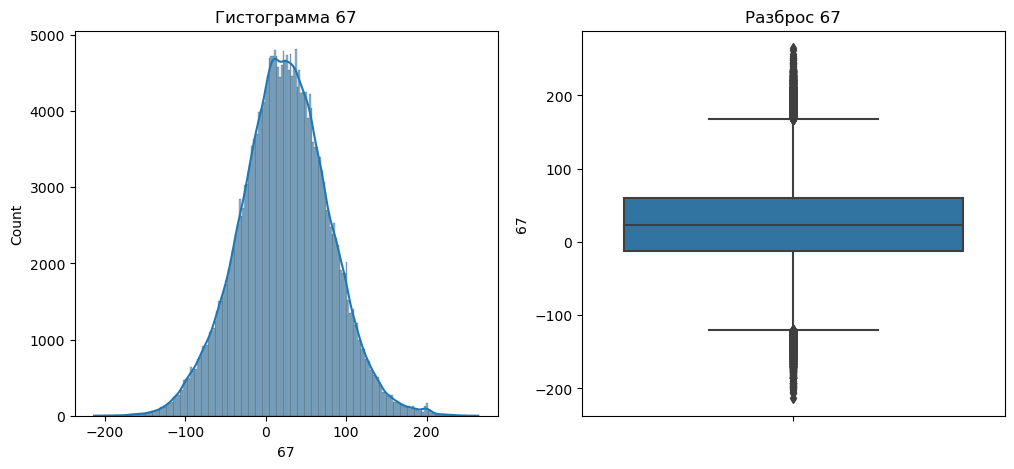

,count,mean,std,min,25%,50%,75%,max
67,291813.0,23.543147,55.353032,-213.49242,-12.501141,23.46163,59.740337,264.3472


Нижняя граница выбросов признака 67: -120.863358
Верхняя граница выбросов признака 67: 168.102554
Количество значений за нижней границей 67: 1315


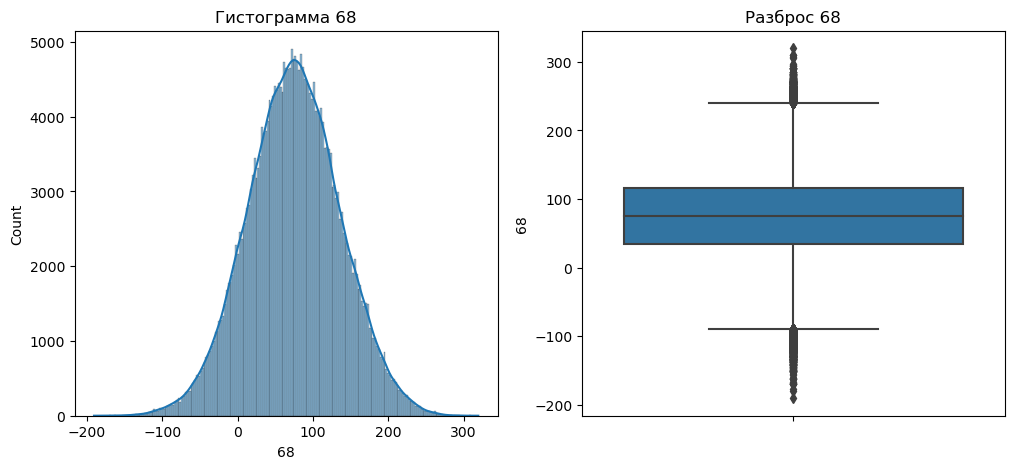

,count,mean,std,min,25%,50%,75%,max
68,291813.0,74.890028,61.320347,-190.48315,33.78482,74.87698,115.89688,319.60104


Нижняя граница выбросов признака 68: -89.38326999999998
Верхняя граница выбросов признака 68: 239.06496999999996
Количество значений за нижней границей 68: 1263


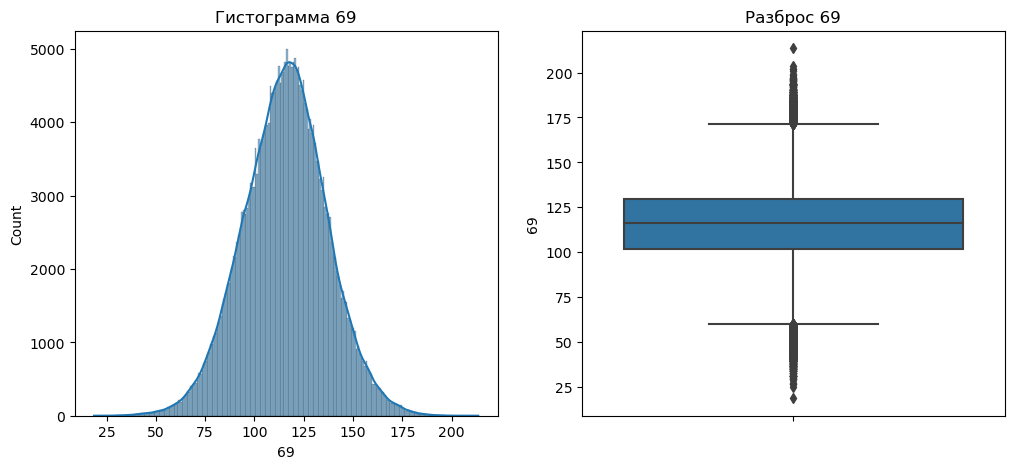

,count,mean,std,min,25%,50%,75%,max
69,291813.0,115.611366,21.219222,18.601448,101.67566,116.04927,129.62595,213.57726


Нижняя граница выбросов признака 69: 59.750225
Верхняя граница выбросов признака 69: 171.55138499999998
Количество значений за нижней границей 69: 1630


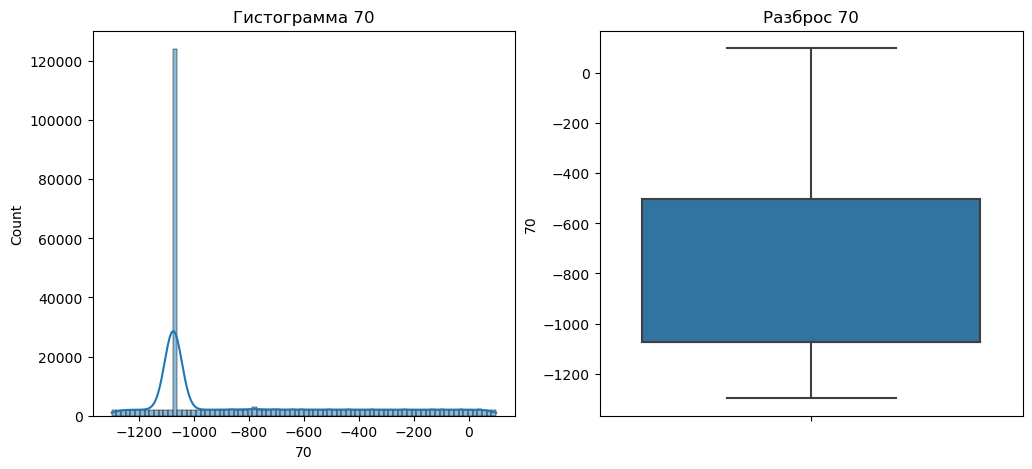

,count,mean,std,min,25%,50%,75%,max
70,291813.0,-798.355219,385.414338,-1297.924962,-1074.464888,-1074.464888,-504.291183,98.770811


Нижняя граница выбросов признака 70: -1929.725445440025
Верхняя граница выбросов признака 70: 350.96937468286393
Количество значений за нижней границей 70: 0


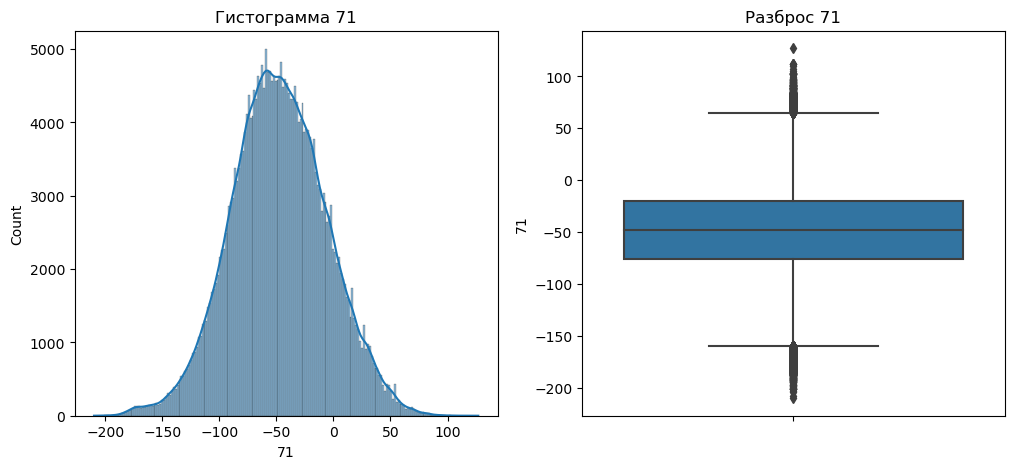

,count,mean,std,min,25%,50%,75%,max
71,291813.0,-47.701336,41.731025,-209.93576,-75.62111,-48.403816,-19.68417,126.97322


Нижняя граница выбросов признака 71: -159.52652
Верхняя граница выбросов признака 71: 64.22124
Количество значений за нижней границей 71: 1697


In [14]:
plot_numerical_features(df_base, num_columns) 

__Результат исследовательского анализа данных:__

- Большинство признаков имеет распределение схожее с нормальным
- Признаки 6, 21, 25, 33, 44, 59, 65, 70 не имеют нормального распределения
- Признаки 21, 25 содержать аномальное большое количество выбросов за нижней границей (22,8 тыс. и 55,6 тыс. наблюдений)

## Анализ корреляции

В связи с наличием большого количества признаков, для улучшения читаемости матрицы применим иерархическую кластеризацию.
Это позволяет упорядочить признаки в матрице корреляции таким образом, чтобы схожие признаки располагались рядом друг с другом.

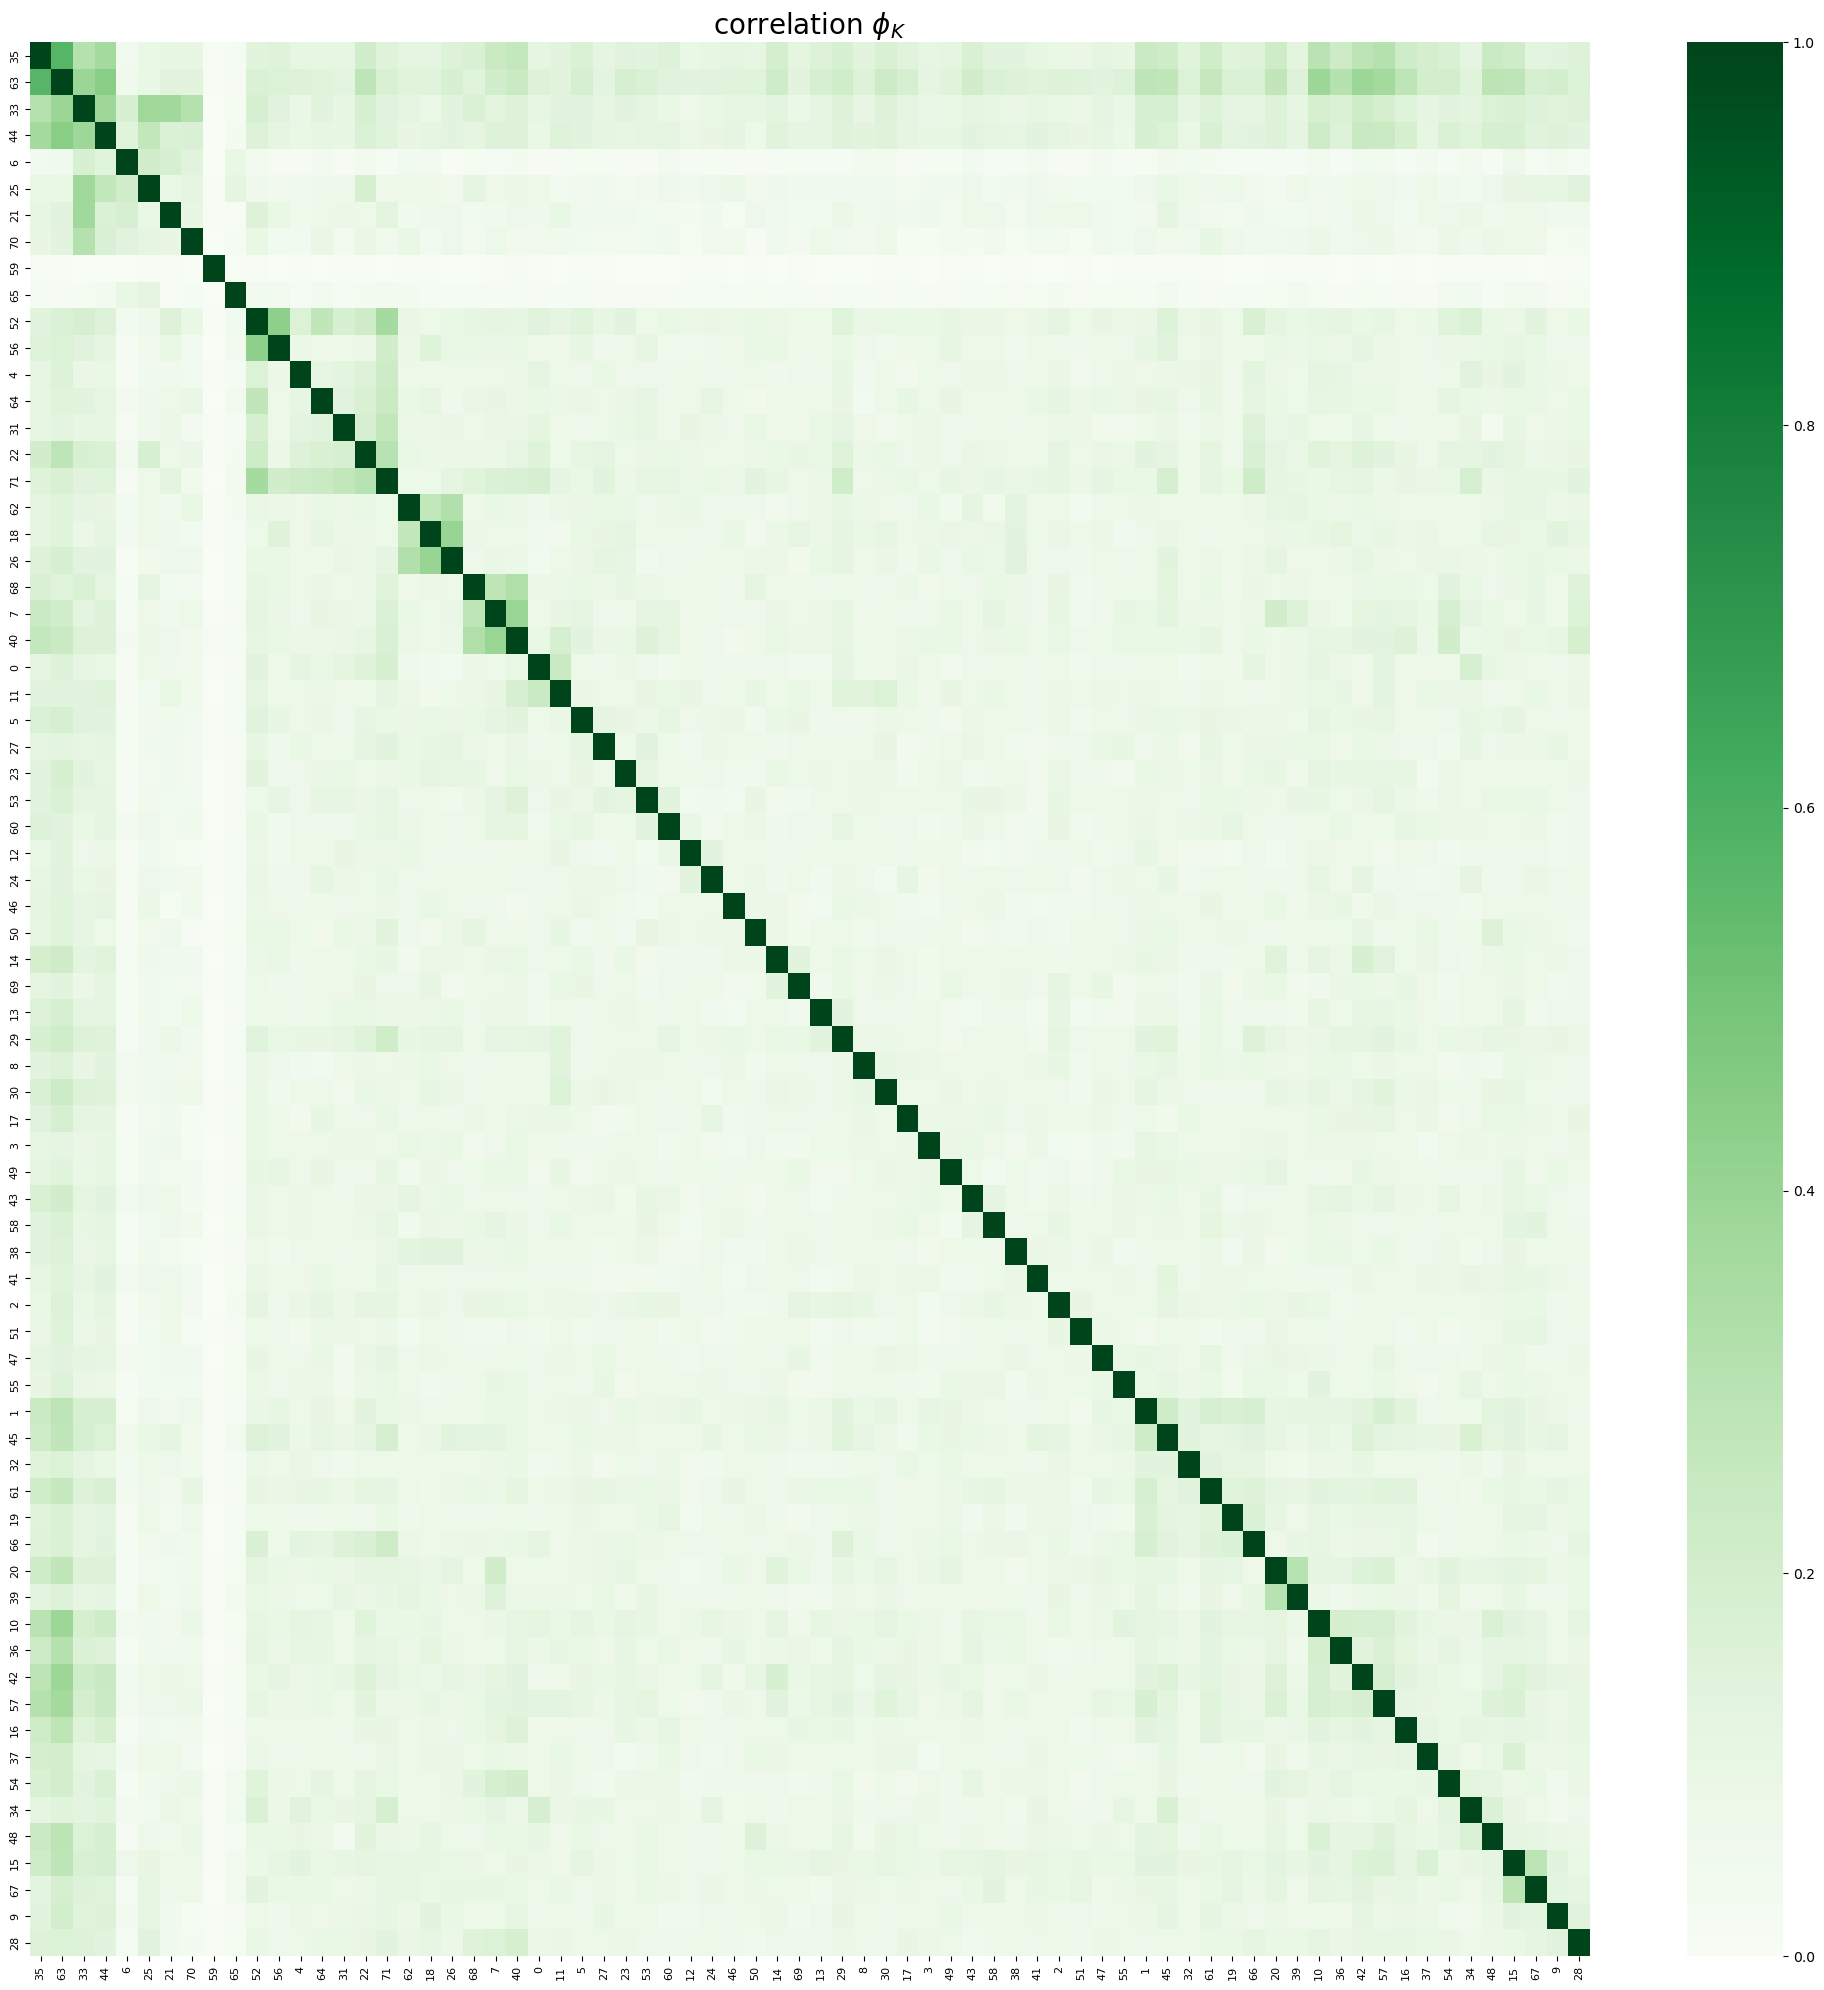

In [15]:
#Сформируем корреляционную матрицу phik
phik_overview = df_base.phik_matrix(interval_cols=num_columns)

#Кластеризация признаков
pairwise_dists = hierarchy.distance.pdist(phik_overview)
clustered = hierarchy.ward(pairwise_dists)
dendro = hierarchy.dendrogram(clustered, labels=phik_overview.columns, no_plot=True)
ordered_cols = dendro['ivl']

#Перестроим матрицу корреляций в соответствии с кластеризацией
phik_ordered = phik_overview.loc[ordered_cols, ordered_cols]

#Построим тепловую карту с аннотациями
plt.figure(figsize=(20, 20))
sns.heatmap(phik_ordered, annot=False, cmap='Greens', vmin=0, vmax=1, xticklabels=ordered_cols, yticklabels=ordered_cols)
plt.title(r'correlation $\phi_K$', fontsize=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [16]:
# Преобразуем матрицу корреляций в DataFrame для удобства работы
phik_overview_df = pd.DataFrame(phik_overview, columns=phik_overview.columns, index=phik_overview.index)

# Уберем диагональные элементы, чтобы избежать выбора самой корреляции с собой
np.fill_diagonal(phik_overview_df.values, np.nan)

# Преобразуем DataFrame в длинный формат для сортировки
phik_long = phik_overview_df.unstack().reset_index()
phik_long.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Отсортируем по убыванию корреляции и выберем 10 наибольших
top_10_correlations = phik_long.sort_values(by='Correlation', ascending=False).head(10)

print(top_10_correlations)

     Feature_1 Feature_2  Correlation
4571        63        35     0.572055
2583        35        63     0.572055
3231        44        63     0.443683
4580        63        44     0.443683
4084        56        52     0.427887
3800        52        56     0.427887
1890        26        18     0.401515
1322        18        26     0.401515
2887        40         7     0.398335
544          7        40     0.398335


__Итоги анализа корреляции:__
- Пары признаков 63 и 35, 44 и 63, 52 и 56, 26 и 18, 40 и 7 демонстрируют наибольшую корреляцию

# Предподготовка данных


In [17]:
#Уберем дубликаты из базового датасета, чтоб обучение прошло без баеса
df_base = df_base.drop_duplicates()

# Извлечение правильных ответов для тренировачного датасета
target_train = df_train["Target"].values

# Приведение тренировачного датасета к корректной размерности
df_train = df_train.drop("Target", axis=1)

# Извлечение правильных ответов для валидационного датасета
target_val = df_ans['Expected'].values

# Обучение моделей

In [18]:
#Функция для оценки качества модели
def evaluate_faiss_index(base, query, answers, n_cells, index_type):
    # Стандартизация данных
    scaler = StandardScaler()
    base_features = scaler.fit_transform(base.values.astype('float32'))
    query_features = scaler.transform(query.values.astype('float32'))

    # Для соответствия идентификаторов с индексами
    base_ids = base.index.values

    # Создаем индекс с обучением
    dimension = base_features.shape[1]
    
    if index_type == 'IVFFlat':
        quantizer = faiss.IndexFlatL2(dimension)
        index = faiss.IndexIVFFlat(quantizer, dimension, n_cells, faiss.METRIC_L2)
    elif index_type == 'HNSW':
        index = faiss.IndexHNSWFlat(dimension, n_cells)
    else:
        raise ValueError("Тип индекса не предусмотрен")

    # Начинаем измерение времени
    start_time = time.time()
    
    # Тренируем индекс на базовом наборе данных (только для IVFFlat)
    if index_type == 'IVFFlat':
        index.train(base_features)

    # Добавляем данные в индекс
    index.add(base_features)

    # Завершаем измерение времени
    training_time = time.time() - start_time

    # Ищем ближайших соседей для валидационного датасета
    k = 5  # Количество ближайших соседей
    distances, indices = index.search(query_features, k)

    # Преобразование индексов в идентификаторы товаров
    predicted_analogs = [[base_ids[idx] for idx in idx_list] for idx_list in indices]

    # Оценка качества
    matches = 0
    for i, correct_id in enumerate(answers):
        if correct_id in predicted_analogs[i]:
            matches += 1

    accuracy_at_5 = matches / len(answers)
    return accuracy_at_5, training_time

#Подбор параметров
def faiss_main(base, query, answers, n_cells_options, index_types):
    best_ivfflat_params = {"n_cells": None, "accuracy": 0, "training_time": None}
    best_hnsw_params = {"n_cells": None, "accuracy": 0, "training_time": None}

    for n_cells in n_cells_options:
        for index_type in index_types:
            accuracy, training_time = evaluate_faiss_index(base, query, answers, n_cells, index_type)
            print(f"n_cells: {n_cells}, index_type: {index_type}, accuracy@5: {accuracy * 100:.2f}%, training_time: {training_time:.2f}s")
            
            if index_type == 'IVFFlat' and accuracy > best_ivfflat_params["accuracy"]:
                best_ivfflat_params["n_cells"] = n_cells
                best_ivfflat_params["accuracy"] = accuracy
                best_ivfflat_params["training_time"] = training_time
            
            if index_type == 'HNSW' and accuracy > best_hnsw_params["accuracy"]:
                best_hnsw_params["n_cells"] = n_cells
                best_hnsw_params["accuracy"] = accuracy
                best_hnsw_params["training_time"] = training_time

In [19]:
# Подбор параметров
n_cells_variants = [100, 125, 150, 175, 200, 225, 250]
index_types = ['IVFFlat', 'HNSW']

# Проверим параметры на тренировачных данных
print("Evaluating for training data:")
faiss_main(df_base, df_train, target_train, n_cells_variants, index_types)

Evaluating for training data:
n_cells: 100, index_type: IVFFlat, accuracy@5: 61.49%, training_time: 0.21s
n_cells: 100, index_type: HNSW, accuracy@5: 72.04%, training_time: 30.30s
n_cells: 125, index_type: IVFFlat, accuracy@5: 61.76%, training_time: 0.29s
n_cells: 125, index_type: HNSW, accuracy@5: 72.15%, training_time: 34.90s
n_cells: 150, index_type: IVFFlat, accuracy@5: 61.58%, training_time: 0.29s
n_cells: 150, index_type: HNSW, accuracy@5: 72.72%, training_time: 30.86s
n_cells: 175, index_type: IVFFlat, accuracy@5: 61.02%, training_time: 0.35s
n_cells: 175, index_type: HNSW, accuracy@5: 73.14%, training_time: 35.59s
n_cells: 200, index_type: IVFFlat, accuracy@5: 61.68%, training_time: 0.48s
n_cells: 200, index_type: HNSW, accuracy@5: 73.34%, training_time: 39.03s
n_cells: 225, index_type: IVFFlat, accuracy@5: 60.64%, training_time: 0.54s
n_cells: 225, index_type: HNSW, accuracy@5: 73.66%, training_time: 33.28s
n_cells: 250, index_type: IVFFlat, accuracy@5: 61.05%, training_time: 

__Модель HNSW показывает более точный показатель accuracy@5, в то время как IVFFLat оказался значительно быстрее. Посмотрим как можно поднять качество моделей__

# Улучшение модели

In [20]:
#Функция для запуска модели без определенных признаков
def evaluate_models_without_features(base, query, answers, best_n_cells, features_to_remove, index_type):
    # Удаление указанных признаков
    base_modified = base.drop(base.columns[features_to_remove], axis=1)
    query_modified = query.drop(query.columns[features_to_remove], axis=1)

    # Оценка модели 
    accuracy, training_time = evaluate_faiss_index(base_modified, query_modified, answers, best_n_cells, index_type)
    print(f"Removed features {features_to_remove}, accuracy@5: {accuracy * 100:.2f}%, training_time: {training_time:.2f}s")
    return accuracy, training_time

In [21]:
# Оптимизация модели без определенных признаков 
features_to_remove = [21, 25, 33, 44, 59, 65, 70]

print("Оптимизация IVFFlat исключая столбцы с ненормальным распределением в training data:")
evaluate_models_without_features(df_base, df_train, target_train, 125, features_to_remove, 'IVFFlat')

print("Оптимизация HNWS исключая столбцы с ненормальным распределением в training data:")
evaluate_models_without_features(df_base, df_train, target_train, 225, features_to_remove, 'HNSW')

Оптимизация IVFFlat исключая столбцы с ненормальным распределением в training data:
Removed features [21, 25, 33, 44, 59, 65, 70], accuracy@5: 68.17%, training_time: 0.22s
Оптимизация HNWS исключая столбцы с ненормальным распределением в training data:
Removed features [21, 25, 33, 44, 59, 65, 70], accuracy@5: 76.94%, training_time: 34.83s


(0.7693769376937694, 34.82659697532654)

__Модель HNWS также показывает большую точность при более продолжительном процессе тренировки, тк точность основной критерий задачи, валидационные данные проверим на HNWS__

In [22]:
#Финальная модель

print("Оптимизация HNWS исключая столбцы с ненормальным распределением в val data:")
evaluate_models_without_features(df_base, df_val, target_val, 225, features_to_remove, 'HNSW')

Оптимизация HNWS исключая столбцы с ненормальным распределением в val data:
Removed features [21, 25, 33, 44, 59, 65, 70], accuracy@5: 76.22%, training_time: 34.93s


(0.7622, 34.92613220214844)

# Заключение

Для подготовки модели мэтчинга имелось 4 датафрейма:

__Итоги изучения датафрейма df_base:__

- Базовый датафрейм имеет 291813 строк, 73 столбца, включая индекс в виде ID и 72 признаков
- Пропуски не обнаружены
- Имеется 11278 дубликатов

__Итоги изучения датафрейма df_train:__
- Датафрейм содержит 9999 строк, 74 столбца, включая индекс в виде ID, 72 признака и столбец с таргетом
- Пропуски не обнаружены
- Дубликатов 243

__Итоги изучения датафрейма df_val:__
- Датафрейм содержит 10000 строк, 73 столбца, включая индекс в виде ID, 72 признака 
- Пропуски не обнаружены
- Дубликатов 265

__Итоги изучения датафрейма df_ans:__
- Датафрейм содержит 10000 строк, 1 столбец с ожидаемым результатом
- Пропуски отсутствуют
- Дубликатов 360

__Результат исследовательского анализа данных:__

- Большинство признаков имеет распределение схожее с нормальным
- Признаки 6, 21, 25, 33, 44, 59, 65, 70 не имеют нормального распределения
- Признаки 21, 25 содержать аномальное большое количество выбросов за нижней границей (22,8 тыс. и 55,6 тыс. наблюдений)

__Итоги анализа корреляции:__

- Пары признаков 63 и 35, 44 и 63, 52 и 56, 26 и 18, 40 и 7 демонстрируют наибольшую корреляцию

__Итоги предподготовки данных:__

- Исключили дубликаты из df_base

__Результаты обучения и улучшения модели:__

- Модель HNSW показывает более точный показатель accuracy@5, в то время как IVFFLat оказался значительно быстрее. 
- Best IVFFlat: n_cells: 125, accuracy@5: 61.76%, training_time: 0.24s
- Best HNSW: n_cells: 225, accuracy@5: 73.50%, training_time: 32.83s
- Оптимизация IVFFlat исключая столбцы с [21, 25, 33, 44, 59, 65, 70], accuracy@5: 68.17%, training_time: 0.26s
- Оптимизация HNWS исключая столбцы [21, 25, 33, 44, 59, 65, 70], accuracy@5: 77.03%, training_time: 36.94s
- Финальная модель HNWS [21, 25, 33, 44, 59, 65, 70], accuracy@5: 76.10%, training_time: 34.28s

__Предложения:__
- Проверить больше гиперпараметров
- Попоробовать обучение на GPU для повышения скорости обучения
- Посмотреть влияние PCA на качество модели


